# Supernovae and Redshift pt. II

In [1]:
# ----------------
# AstroML packages
from astroML.datasets import generate_mu_z
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import LinearRegression
from astroML.linear_model import NadarayaWatson

# ----------------
# Astropy packages
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# -----------------
# Scipy
from scipy.optimize import fmin_cobyla
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import uniform
from tqdm import tqdm

# -----------------
# MCMC sampling
import emcee
import dynesty
from dynesty.utils import resample_equal
import corner

# -----------------
# Sklearn
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# -----------------
# Plot stuff
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

/home/ario/anaconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


(35.0, 50.0)

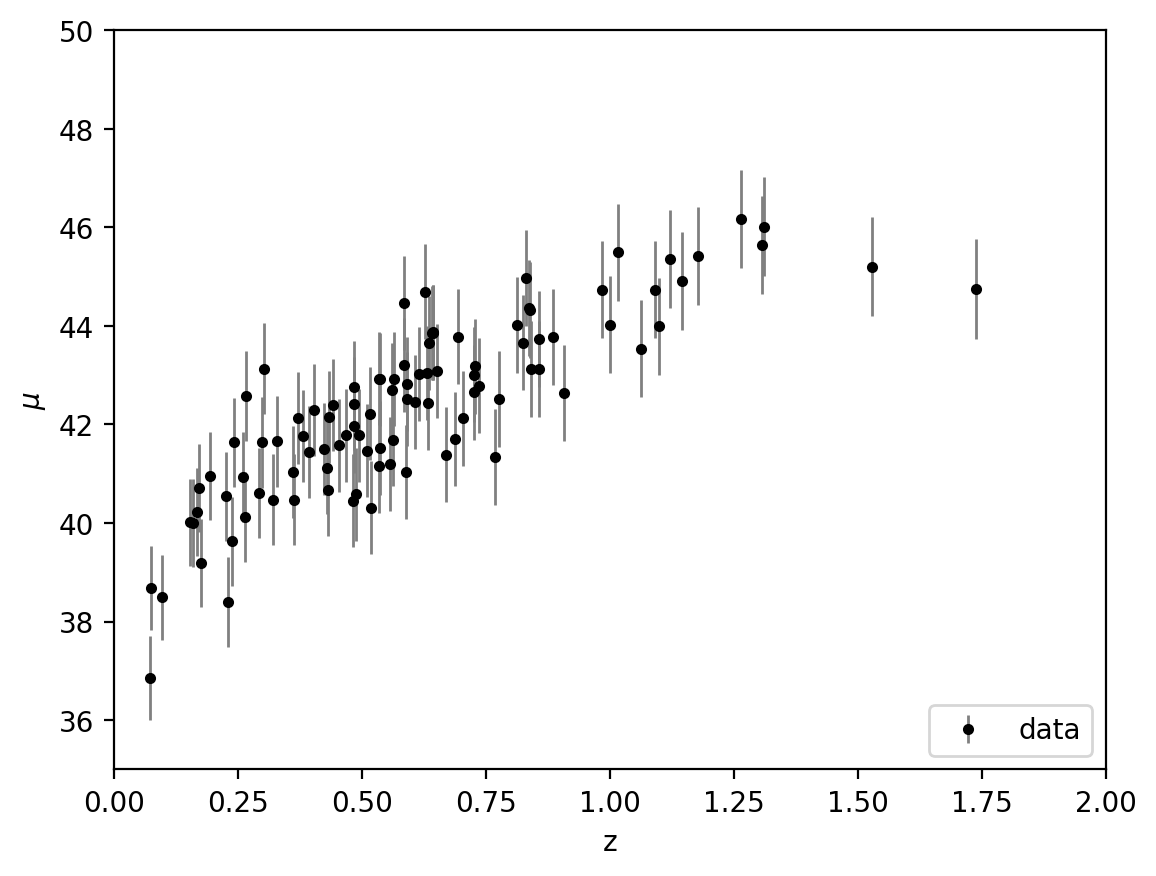

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [3]:
# -----------------------------------------------------------
# Real Distribution
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

(35.0, 50.0)

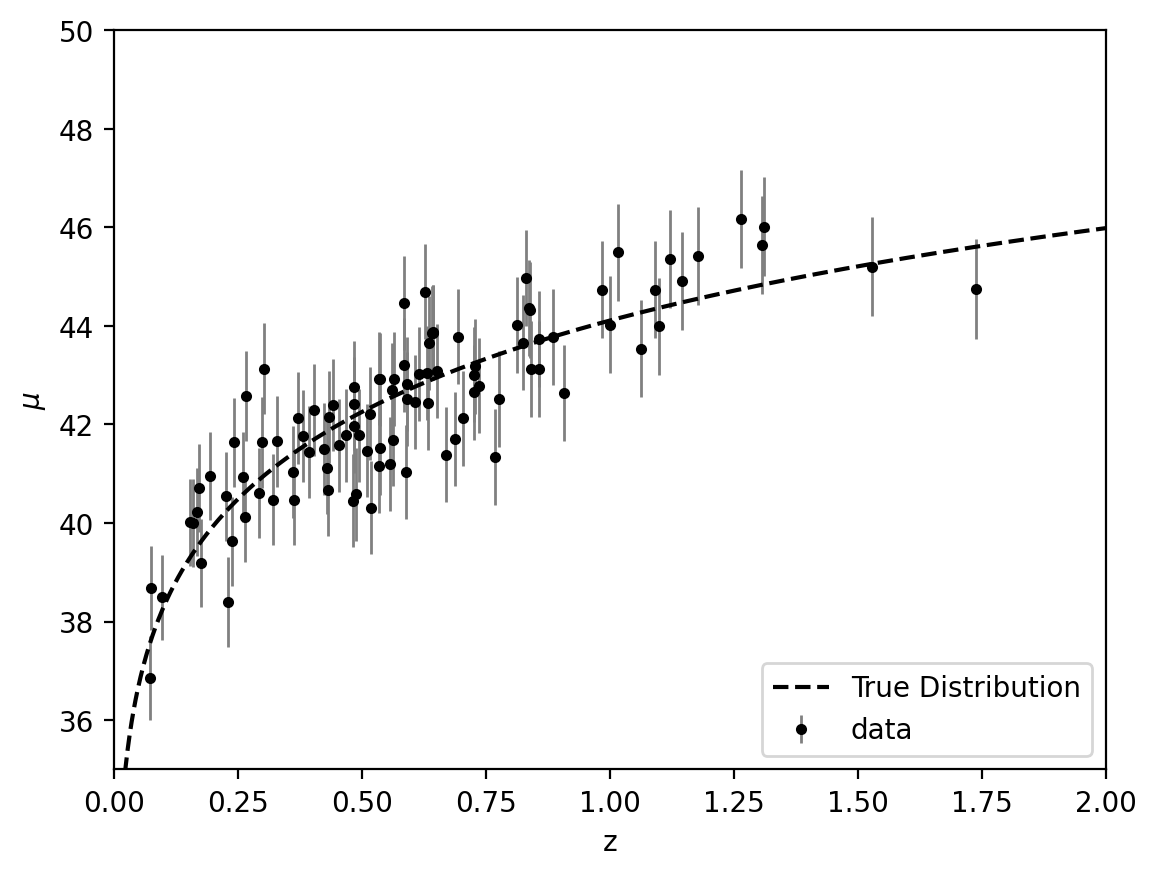

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, color='black', linestyle='dashed', label='True Distribution')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## GPR

In [5]:
# --------------------------------
# Function that computes the error
def error(X, y, regressor):
    return np.sqrt(np.sum((y-regressor.predict(X))**2)/len(X))

def cv_train_error(X, y, dy, regressor_type, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=10)

    train_error = []
    cv_error   = []
    for train_index, cv_index in kf.split(X):
        current_alpha = dy[train_index]**2
        regressor_type.alpha = current_alpha
        
        regressor_type.fit(X[train_index], y[train_index])

        train_error.append(error(X[train_index], y[train_index], regressor_type))
        cv_error.append(error(X[cv_index], y[cv_index], regressor_type))

    return np.median(train_error), np.median(cv_error)

In [6]:
dataset = np.array((z_sample, mu_sample, dmu)).T

dataset_sorted = dataset[dataset[:,0].argsort()]
dataset.shape

(100, 3)

In [7]:
# --------------------------------------
# Split the data in a train and a CV set
X_train, X_cv, ydy_train, ydy_cv = train_test_split(dataset_sorted[:, 0], np.array([dataset_sorted[:, 1],dmu]).T, test_size=0.2, random_state=1)  # ydy to have also errors to work with
Y_train, dy_train = ydy_train.T
Y_cv,dy_cv = ydy_cv.T

In [8]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from sklearn.gaussian_process import GaussianProcessRegressor

In [9]:
# Amplitude parameter of the (constant) Kernel
constants = np.linspace(0.1, 10, 20)

# Values for the length scale parameter of the (RBF) Kernel
scale_len = np.linspace(1, 30, 20)

# Cross Validation Error Matrix
cv_error_matrix = np.zeros((20,20))

for i in tqdm(range(0, len(constants))):
    for j in range(0, len(scale_len)):
        # Kernel is the product between a constant carnel and Radial Basis Function Kernel
        kernel = ConstantKernel(constants[i], (1e-3, 1e4)) * RBF(scale_len[j], (1e-2, 1e2))
        # Instantiate a GPR using the constructed kernel, dmu represents uncert. in the data
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
        # Compute training and cross validation error
        train_error, cv_error = cv_train_error(dataset[:,0][:,None], dataset[:,1], dataset[:,2], gpr, 10)
        # Fill the CV Error Matrix
        cv_error_matrix[i,j] = cv_error

100%|███████████████████████████████████████████| 20/20 [00:41<00:00,  2.09s/it]


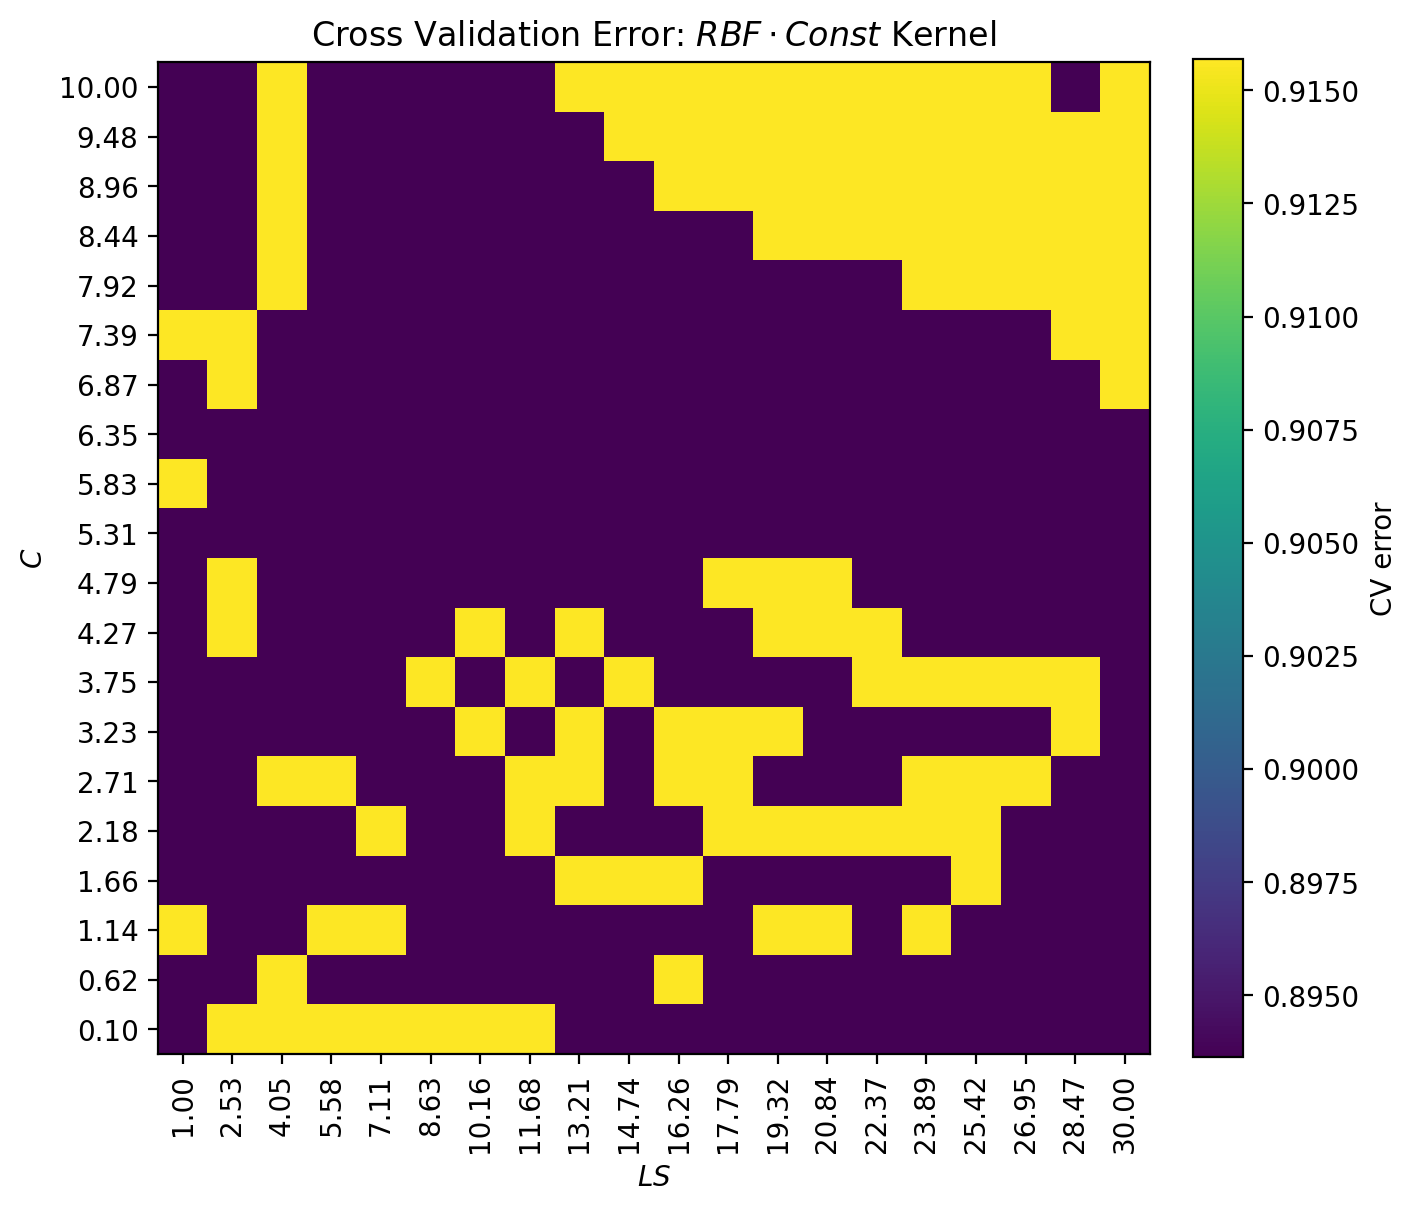

In [10]:
fig = plt.figure(figsize=(7, 7))

plt.imshow(cv_error_matrix, origin='lower')
cbar = plt.colorbar(label='CV error', fraction=0.046, pad=0.04)  # Adatta `fraction` e `pad` se necessario
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')

# Imposta le etichette dell'asse y con due cifre decimali
plt.yticks(np.arange(0, len(constants)), [f"{c:.2f}" for c in constants])

# Imposta le etichette dell'asse x con due cifre decimali, con rotazione verticale
plt.xticks(np.arange(0, len(scale_len)), [f"{s:.2f}" for s in scale_len], rotation='vertical')

plt.title('Cross Validation Error: ${RBF} \cdot {Const}$ Kernel')
plt.show();

In [11]:
np.where(cv_error_matrix == np.min(cv_error_matrix))

(array([9]), array([15]))

In [12]:
best_constant  = constants[np.where(cv_error_matrix == np.min(cv_error_matrix))[0][0]]
best_scale_len = scale_len[np.where(cv_error_matrix == np.min(cv_error_matrix))[1][0]]

print('Best Constant: ', best_constant)
print('Best Scale Length:', best_scale_len)

Best Constant:  4.7894736842105265
Best Scale Length: 23.894736842105264


In [13]:
# Define the Kernel for the Gaussian Process
# The RBF kernel uses a "length scale" (here starting at 10) 
# to define how close points need to be to influence each other
kernel = ConstantKernel(best_constant, (1e-3, 1e3)) * RBF(best_scale_len, (1e-2, 1e2))

# Set up the regressor with the specified kernel:
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)

# Fit the Gaussian Process to the observed data
gpr.fit(z_sample[:,None], mu_sample)

# Use the trained Gaussian Process to make predictions
mu_fit, sigma = gpr.predict(z[:,None], return_std=True)

(35.0, 50.0)

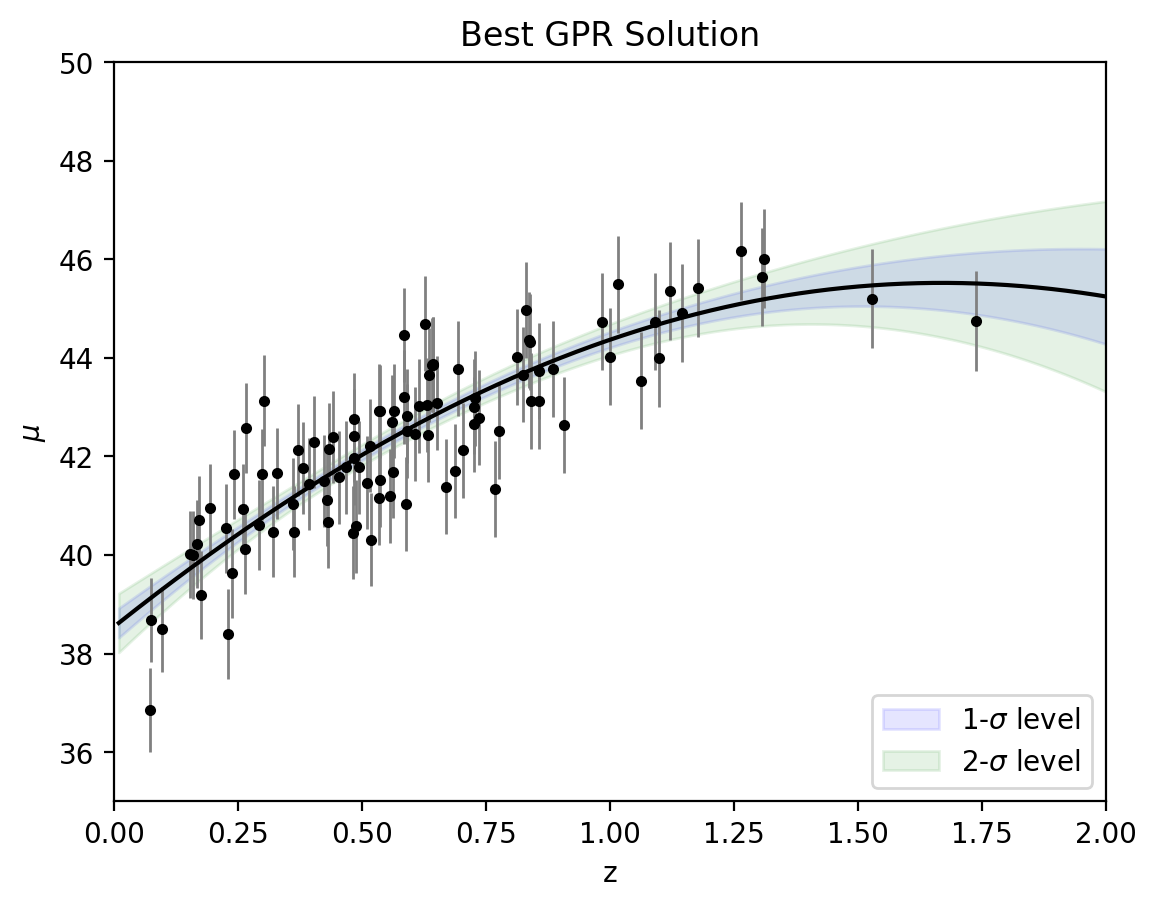

In [14]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.plot(z, mu_fit, '-k')

plt.fill_between(z, mu_fit - sigma, 
                mu_fit + sigma,
                alpha=0.1, color='b', 
                label='1-$\sigma$ level')

plt.fill_between(z, mu_fit - 2* sigma, 
                mu_fit + 2* sigma,
                alpha=0.1, color='g', 
                label='2-$\sigma$ level')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Best GPR Solution')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## Parameter Estimation
We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

In [15]:
# Computes the distance modulus for a given redshift
def fit_curve(z, H0, Om0):
    if Om0 > 0:  # It must be greater than zero
        curve = FlatLambdaCDM(H0=H0, Om0=Om0)
        return curve.distmod(z).value
    return 0

In [17]:
parameters, covariance = curve_fit(fit_curve, dataset[:,0], dataset[:,1])
print(f'Parameters: {parameters}')
print(f'Covariance: {covariance}')

Parameters: [70.37098686  0.27732285]
Covariance: [[55.98071976 -1.67771546]
 [-1.67771546  0.05975194]]


In [18]:
from IPython.display import display, Math

In [20]:
display(Math(fr'\Omega_{{m0}} = {parameters[0]:.2f} \pm {np.sqrt(covariance[0, 0]):.2f}'))
display(Math(fr'H_{{0}} = {parameters[1]:.2f} \pm {np.sqrt(covariance[1, 1]):.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Are these two values correlated? Let's look at the **covariance matrix**.

In [21]:
print(covariance)

[[55.98071976 -1.67771546]
 [-1.67771546  0.05975194]]


### MCMC Sampling
I need to define the *model*, the *log prior*, the *log likelihood* and the *log posterior*. 

In [22]:
# Computes the theoretical distance modulus for a flat LambdaCDM model
def Model(parameters, z):
    Om0, H0 = parameters
    if Om0 > 0:
        curve = FlatLambdaCDM(H0=H0, Om0=Om0)
        return curve.distmod(z).value

    return 0

# Log prior probability distribution for my parameters 
def log_prior(parameters):
    Om0, H0 = parameters
    # uniform (flat) prior
    if 50 < H0 < 100 and 0.1 < Om0 < 1:
        return 0.0
    else:
        return -np.inf

# Log likelihood (agreement between model and the observed data)
def log_likelihood(parameters, z, mu, dmu):
    model = Model(parameters, z)

    logL = - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu-model)/dmu)**2)
    return logL
    
# Log posterior = log L + Log Prior
def log_posterior(parameters, z, mu, dmu):
    return log_likelihood(parameters, z, mu, dmu) + log_prior(parameters)

In [23]:
n_dim     = 2      # number of parameters (H0, Om0)
n_walkers = 5      # number of MCMC walkers
n_step    = 10000  # number of MCMC steps for each walker

starting_guesses = np.array([0.5,80]) + 1e-1* np.random.randn(n_walkers, n_dim)
print('Starting Guesses:')
print(starting_guesses)

Starting Guesses:
[[ 0.44929032 79.90581727]
 [ 0.6932211  79.97222471]
 [ 0.36675501 79.9234136 ]
 [ 0.61923195 80.05291485]
 [ 0.49707224 80.06342278]]


In [26]:
# Run the MCMC Sampling
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(dataset[:,0], dataset[:,1], dataset[:,2]))
sampler.run_mcmc(starting_guesses, n_step, progress=True)
None

100%|████████████████████████████████████| 10000/10000 [00:36<00:00, 275.99it/s]


#### Traceplots

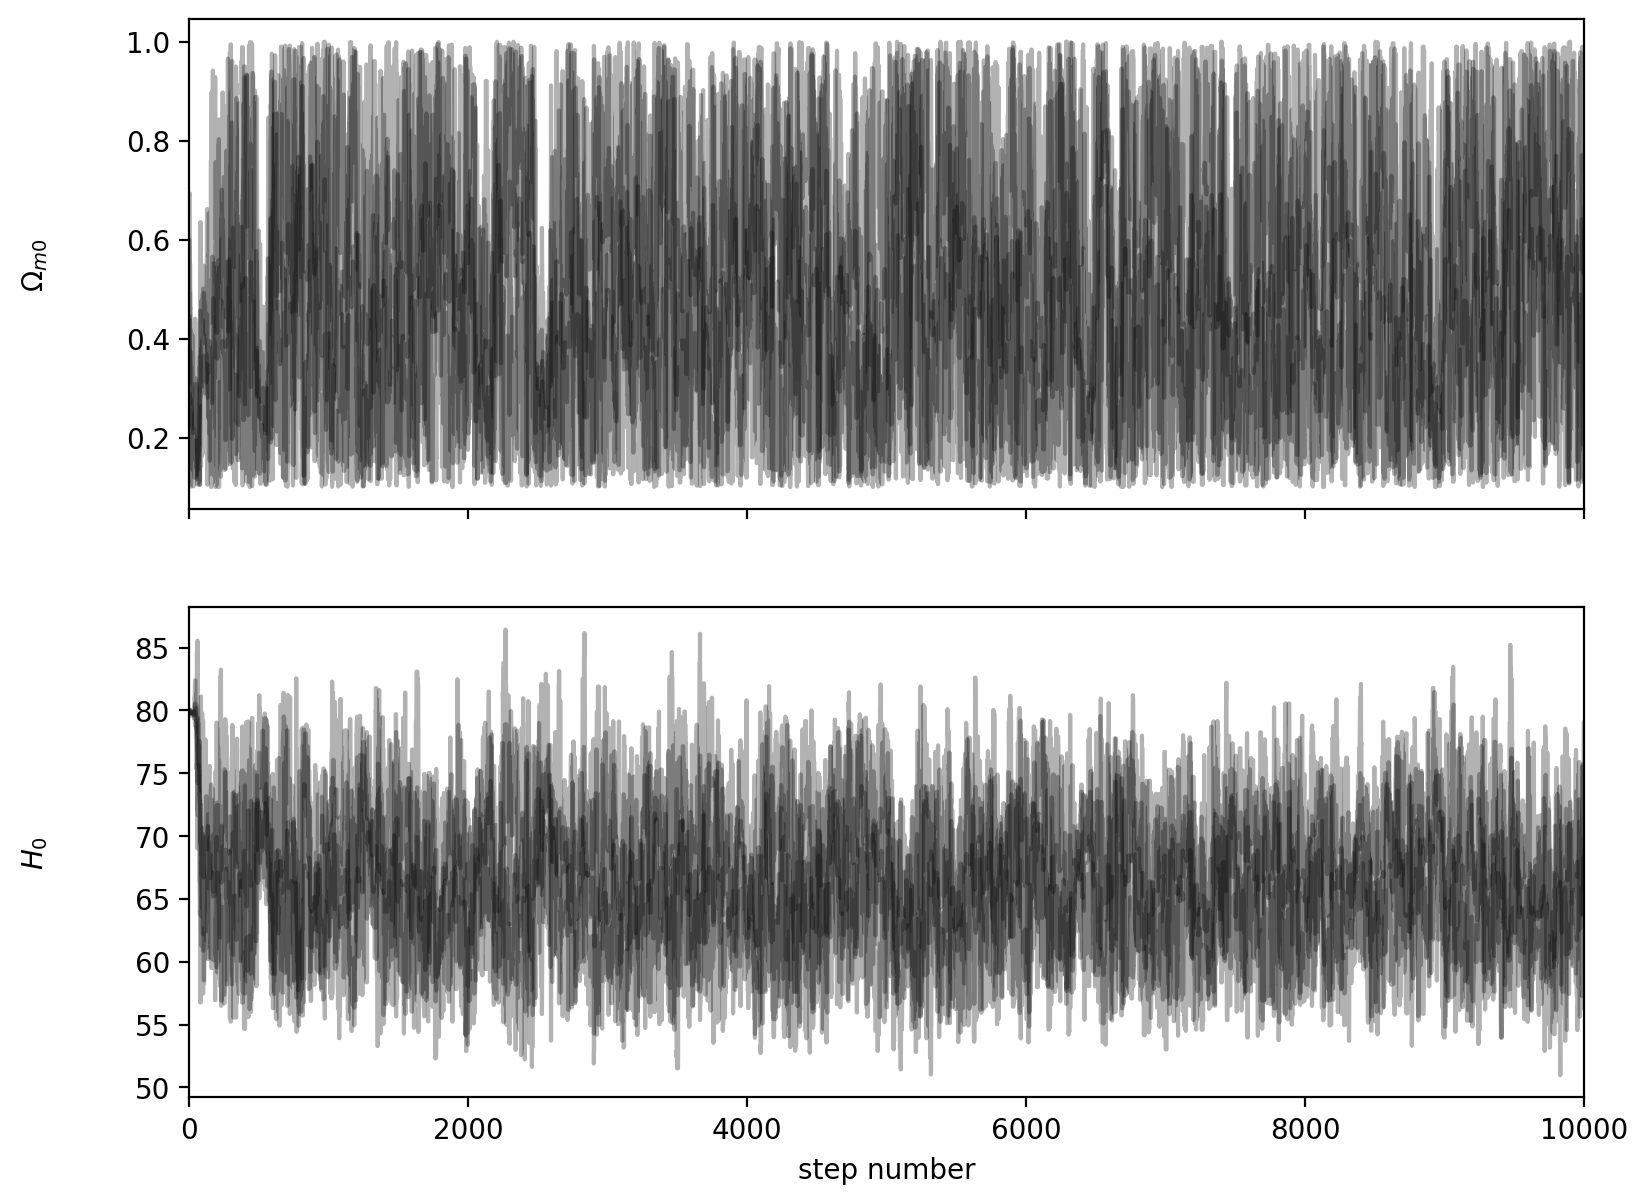

In [27]:
fig, axes = plt.subplots(2, figsize=(9, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"$\Omega_{m0}$", r"$H_0$"]

for i in range(0, n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c="k", alpha=0.3)
    ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Autocorrelation time and burn-in.

In [28]:
# Compute Auto Correlation Time and set the burn_in
tau  = sampler.get_autocorr_time()
burn = 200

flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True)

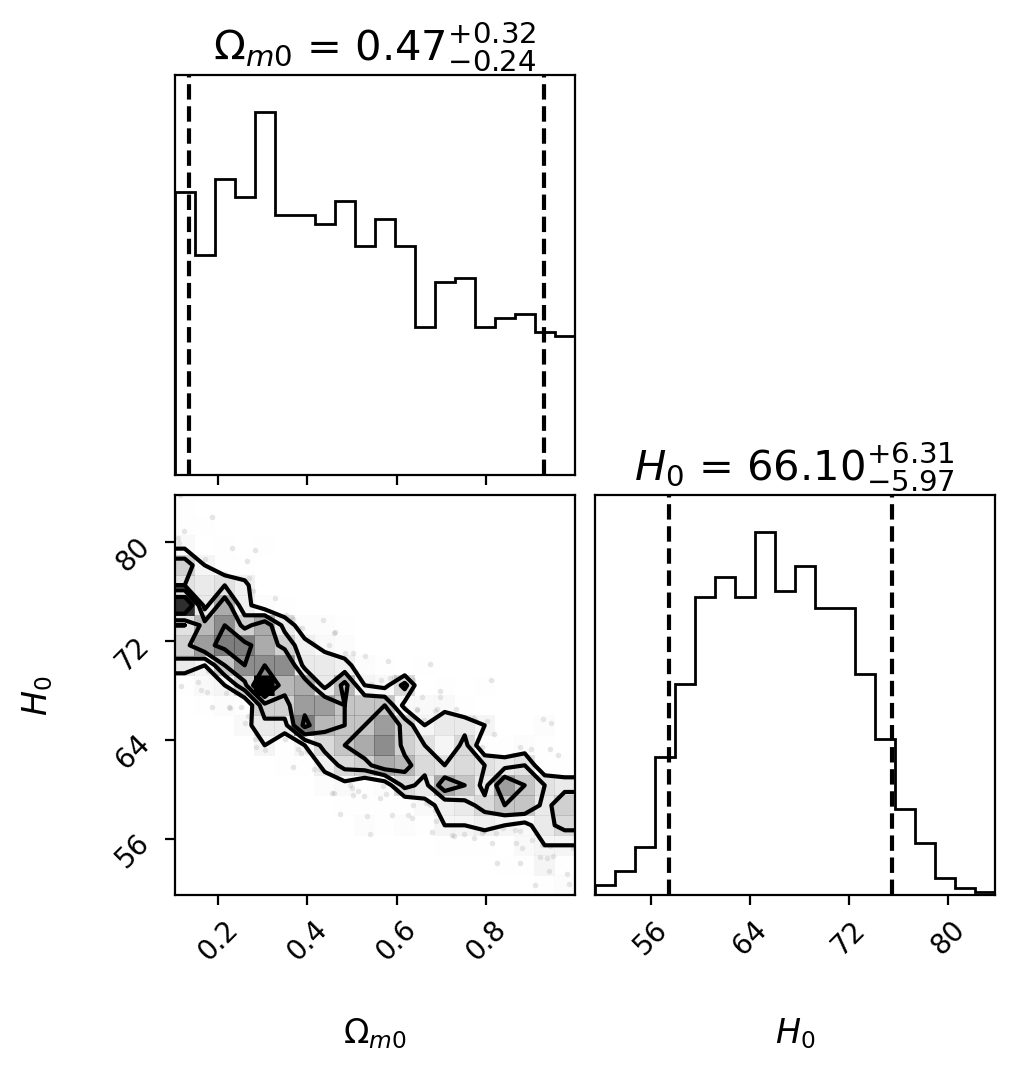

In [29]:
#  Explicitly define the title quantiles (lower, median, upper)
title_quantiles = [0.16, 0.5, 0.84]       # Lower (16%), median (50%), upper (84%) quantiles

# Plotting
fig = corner.corner(
    flat_samples, 
    labels=[r"$\Omega_{m0}$", r"$H_0$"], 
    quantiles=[0.05, 0.95],               # These are for the confidence intervals of the plots
    title_quantiles=title_quantiles,      # Set quantiles to display in the titles
    show_titles=True, 
    title_kwargs={"fontsize": 15}, 
    label_kwargs=dict(fontsize=12)
)

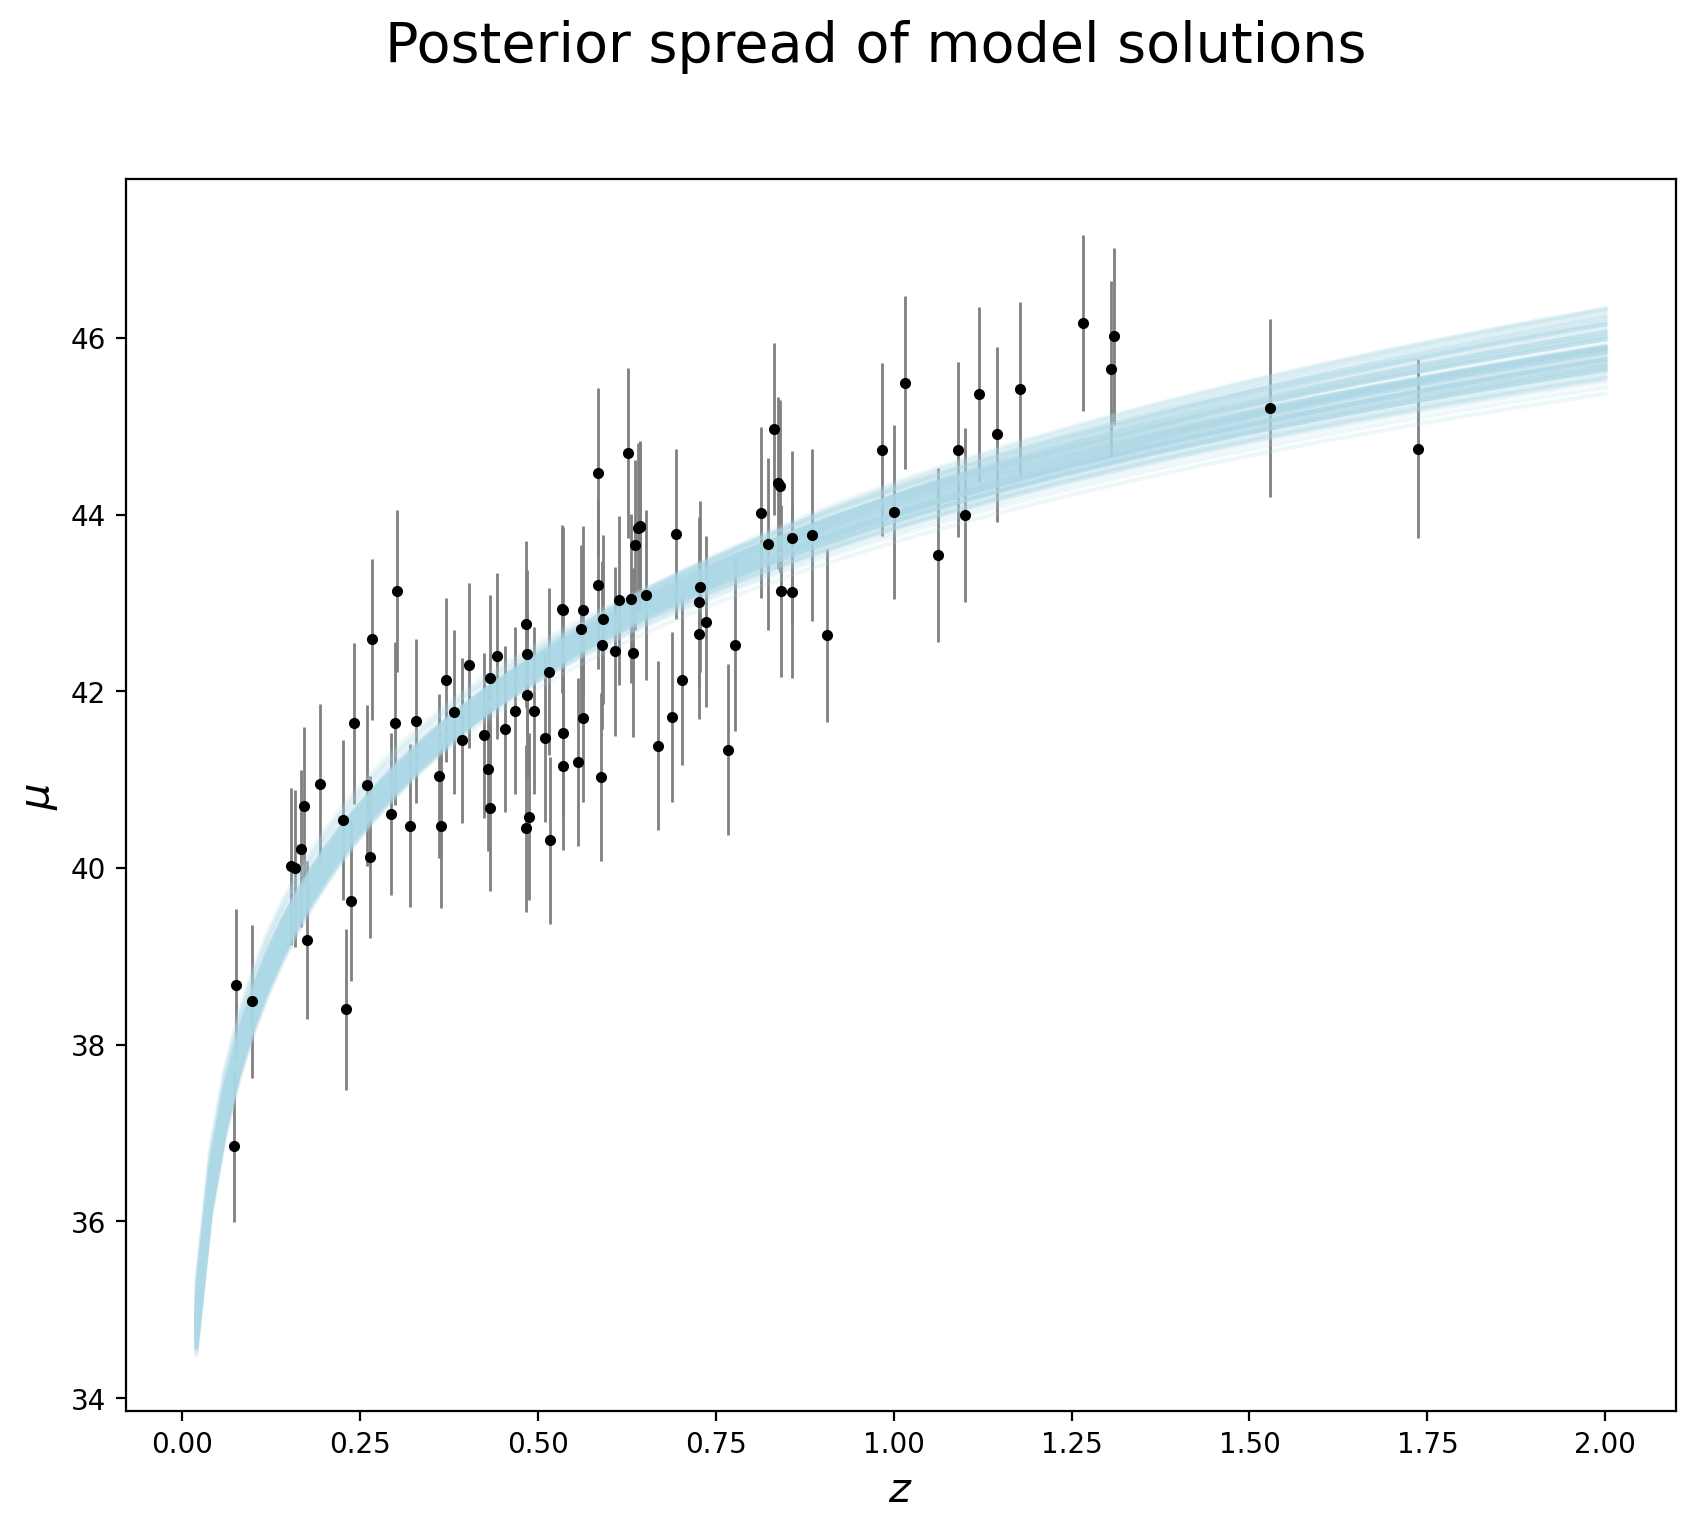

In [31]:
import scipy.stats
z_plot = np.linspace(0,2,100)

#plot section:

plt.figure(figsize=(10, 8))
plt.errorbar(dataset_sorted[:, 0], dataset_sorted[:, 1], dataset_sorted[:,2], fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("$z$", size=15)
plt.ylabel("$\mu$", size=15)
plt.suptitle("Posterior spread of model solutions", size=20);


for i in range(0, 100): 
    
    chosen_post = int(scipy.stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], z_plot)
    
    plt.plot(z_plot, my_Model, alpha=0.2, c='lightblue')

### Nested Sampling

In [32]:
n_dim = 2  # dimensionality of the problem

# Transform for the (here) uniform prior
def ptform(parameters): 
    Om0, H0 = parameters
    x       = np.array(parameters)
    x[0]    = scipy.stats.uniform.ppf(Om0, 0, 1)
    x[1]    = scipy.stats.uniform.ppf(H0, 50, 100)

    return x

def log_likelihood_dynesty(parameters, z, mu, dmu):
    model = Model(parameters, z)

    logL = - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu-model)/dmu)**2)
    return logL   

In [33]:
sampler = dynesty.NestedSampler(log_likelihood_dynesty, ptform, n_dim, nlive=300, logl_args=[dataset[:,0], dataset[:,1], dataset[:,2]])

sampler.run_nested()
sample_results = sampler.results

1265it [00:15, 83.87it/s, +300 | bound: 1 | nc: 1 | ncall: 11631 | eff(%): 13.812 | loglstar:   -inf < -132.815 <    inf | logz: -135.727 +/-  0.078 | dlogz:  0.001 >  0.309]


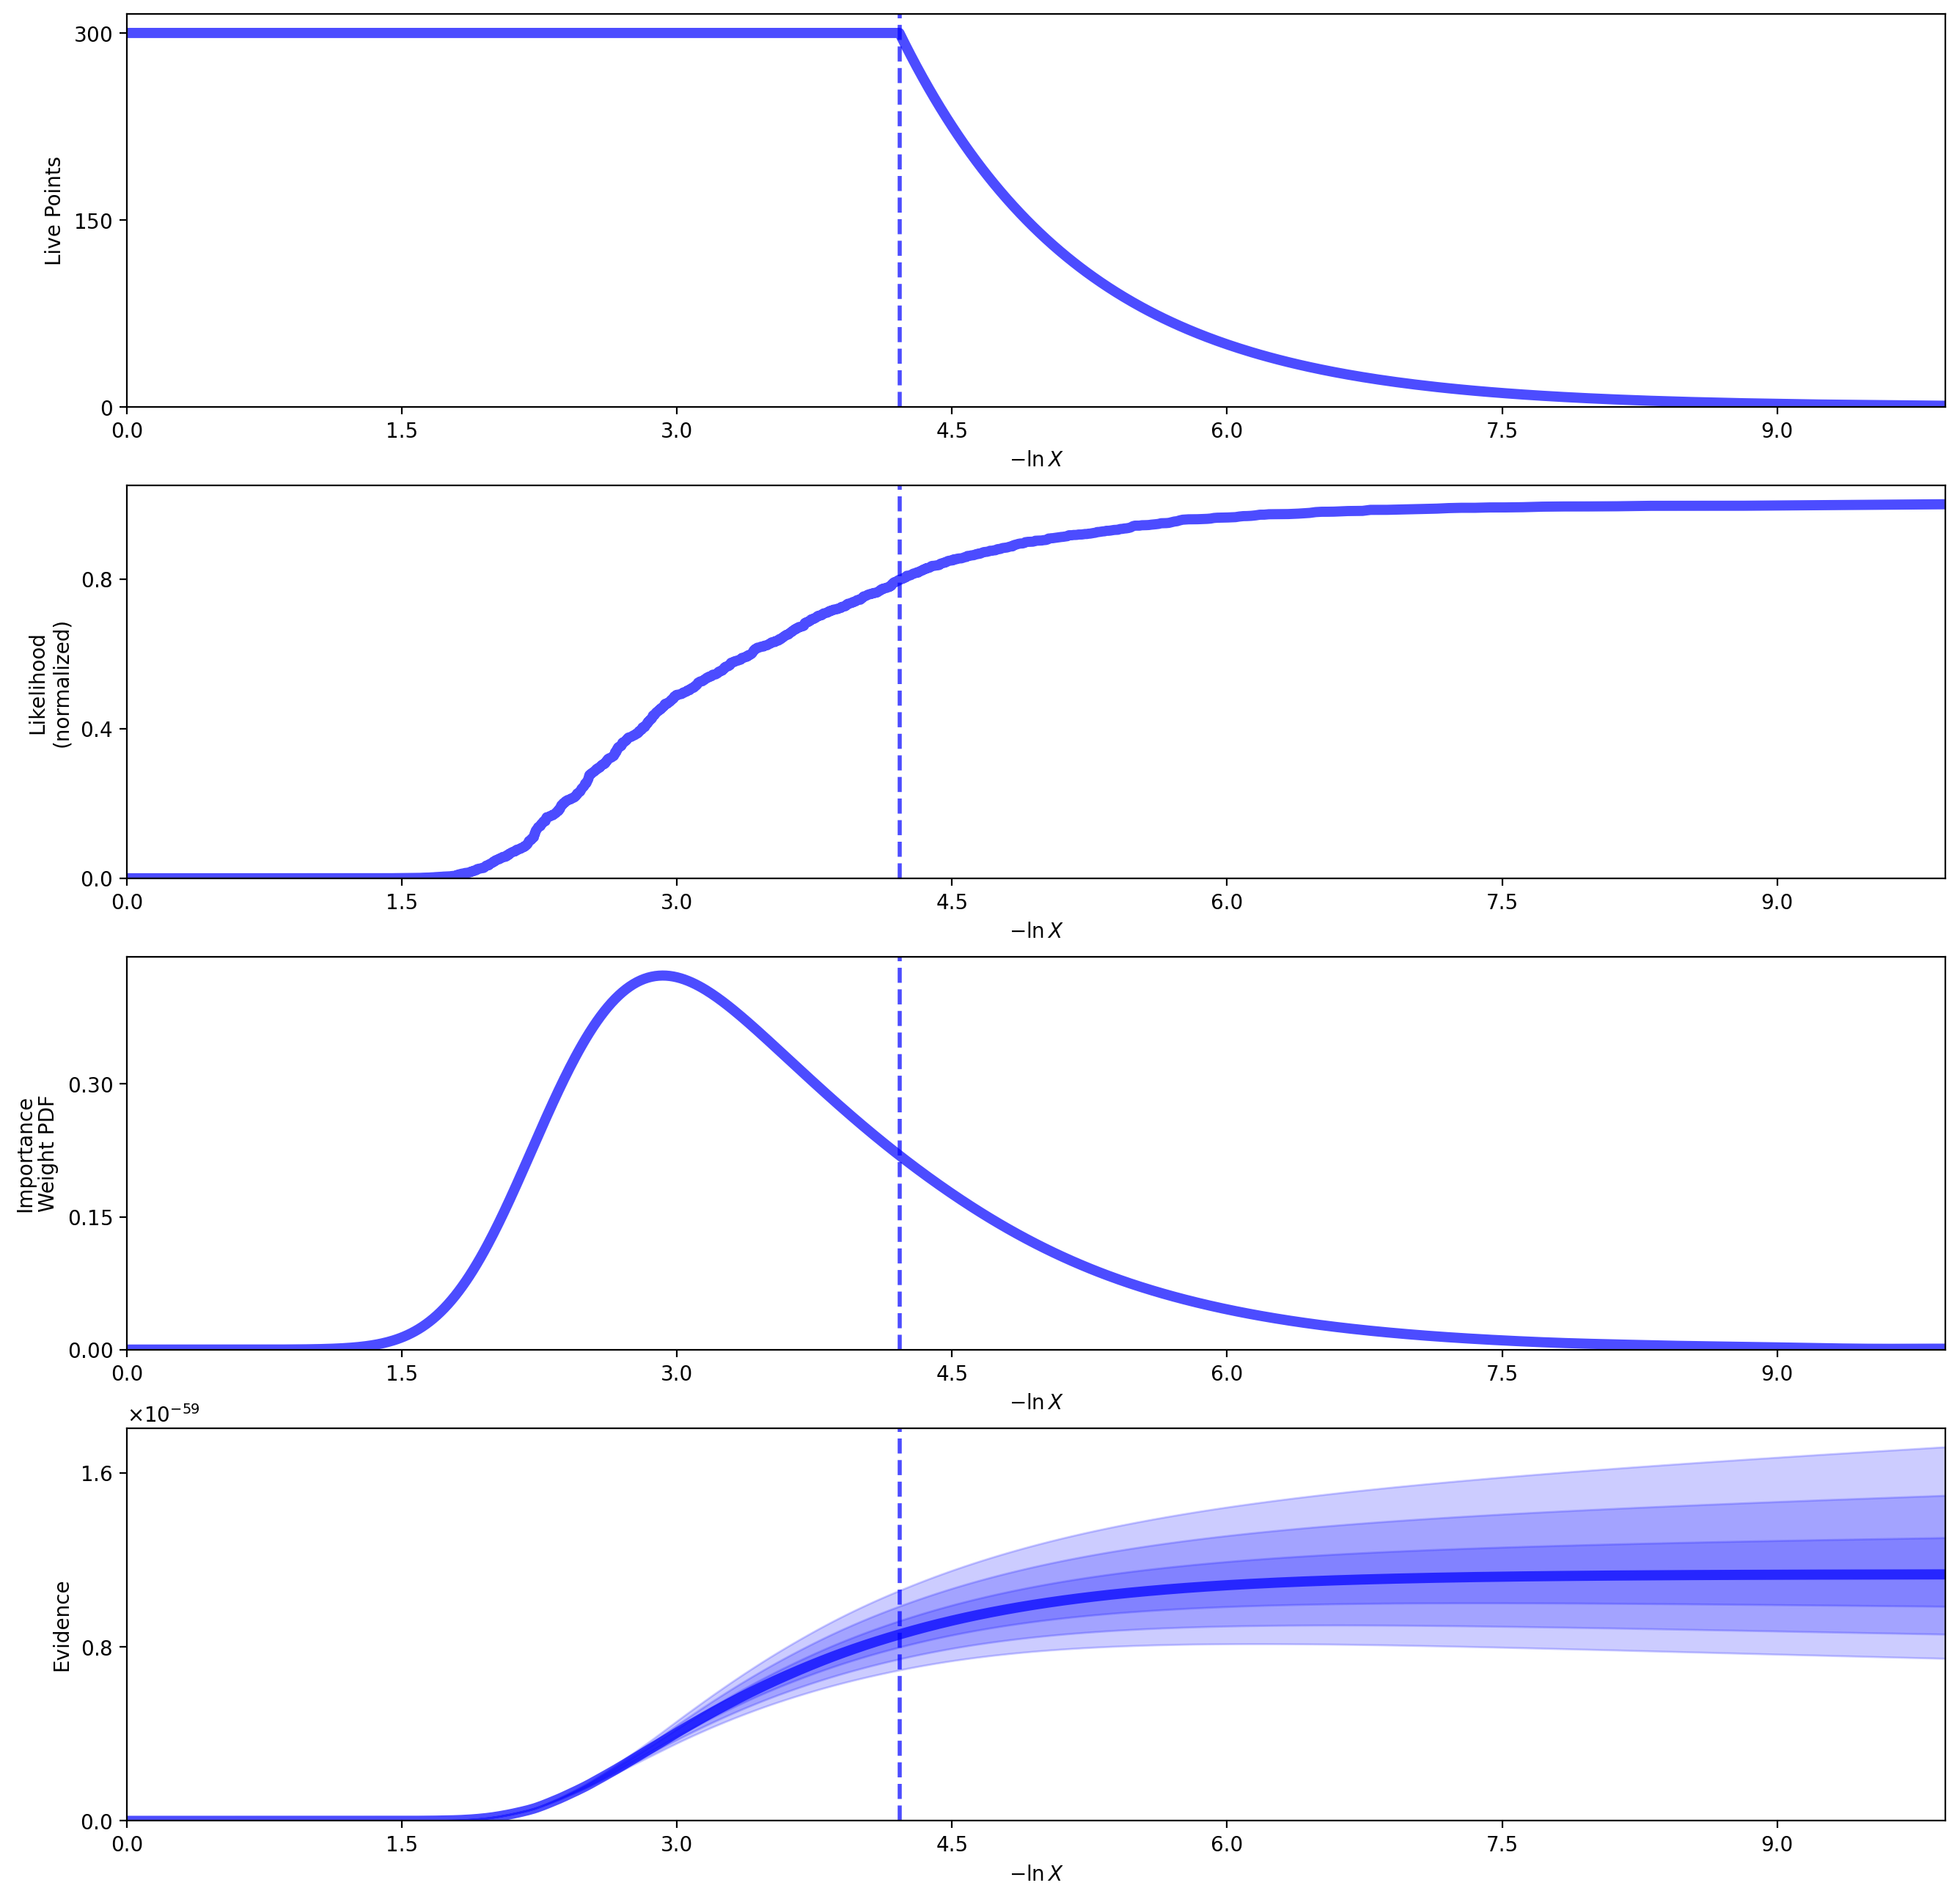

In [34]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sample_results)

In [35]:
logZdynesty = sample_results.logz[-1]
logZerrdyn  = sample_results.logzerr[-1]

In [36]:
display(Math(fr'\text{{Marginalized Evidence}} = {logZdynesty:.2f} \pm {logZerrdyn:.2f}'))


<IPython.core.display.Math object>

#### Traceplots

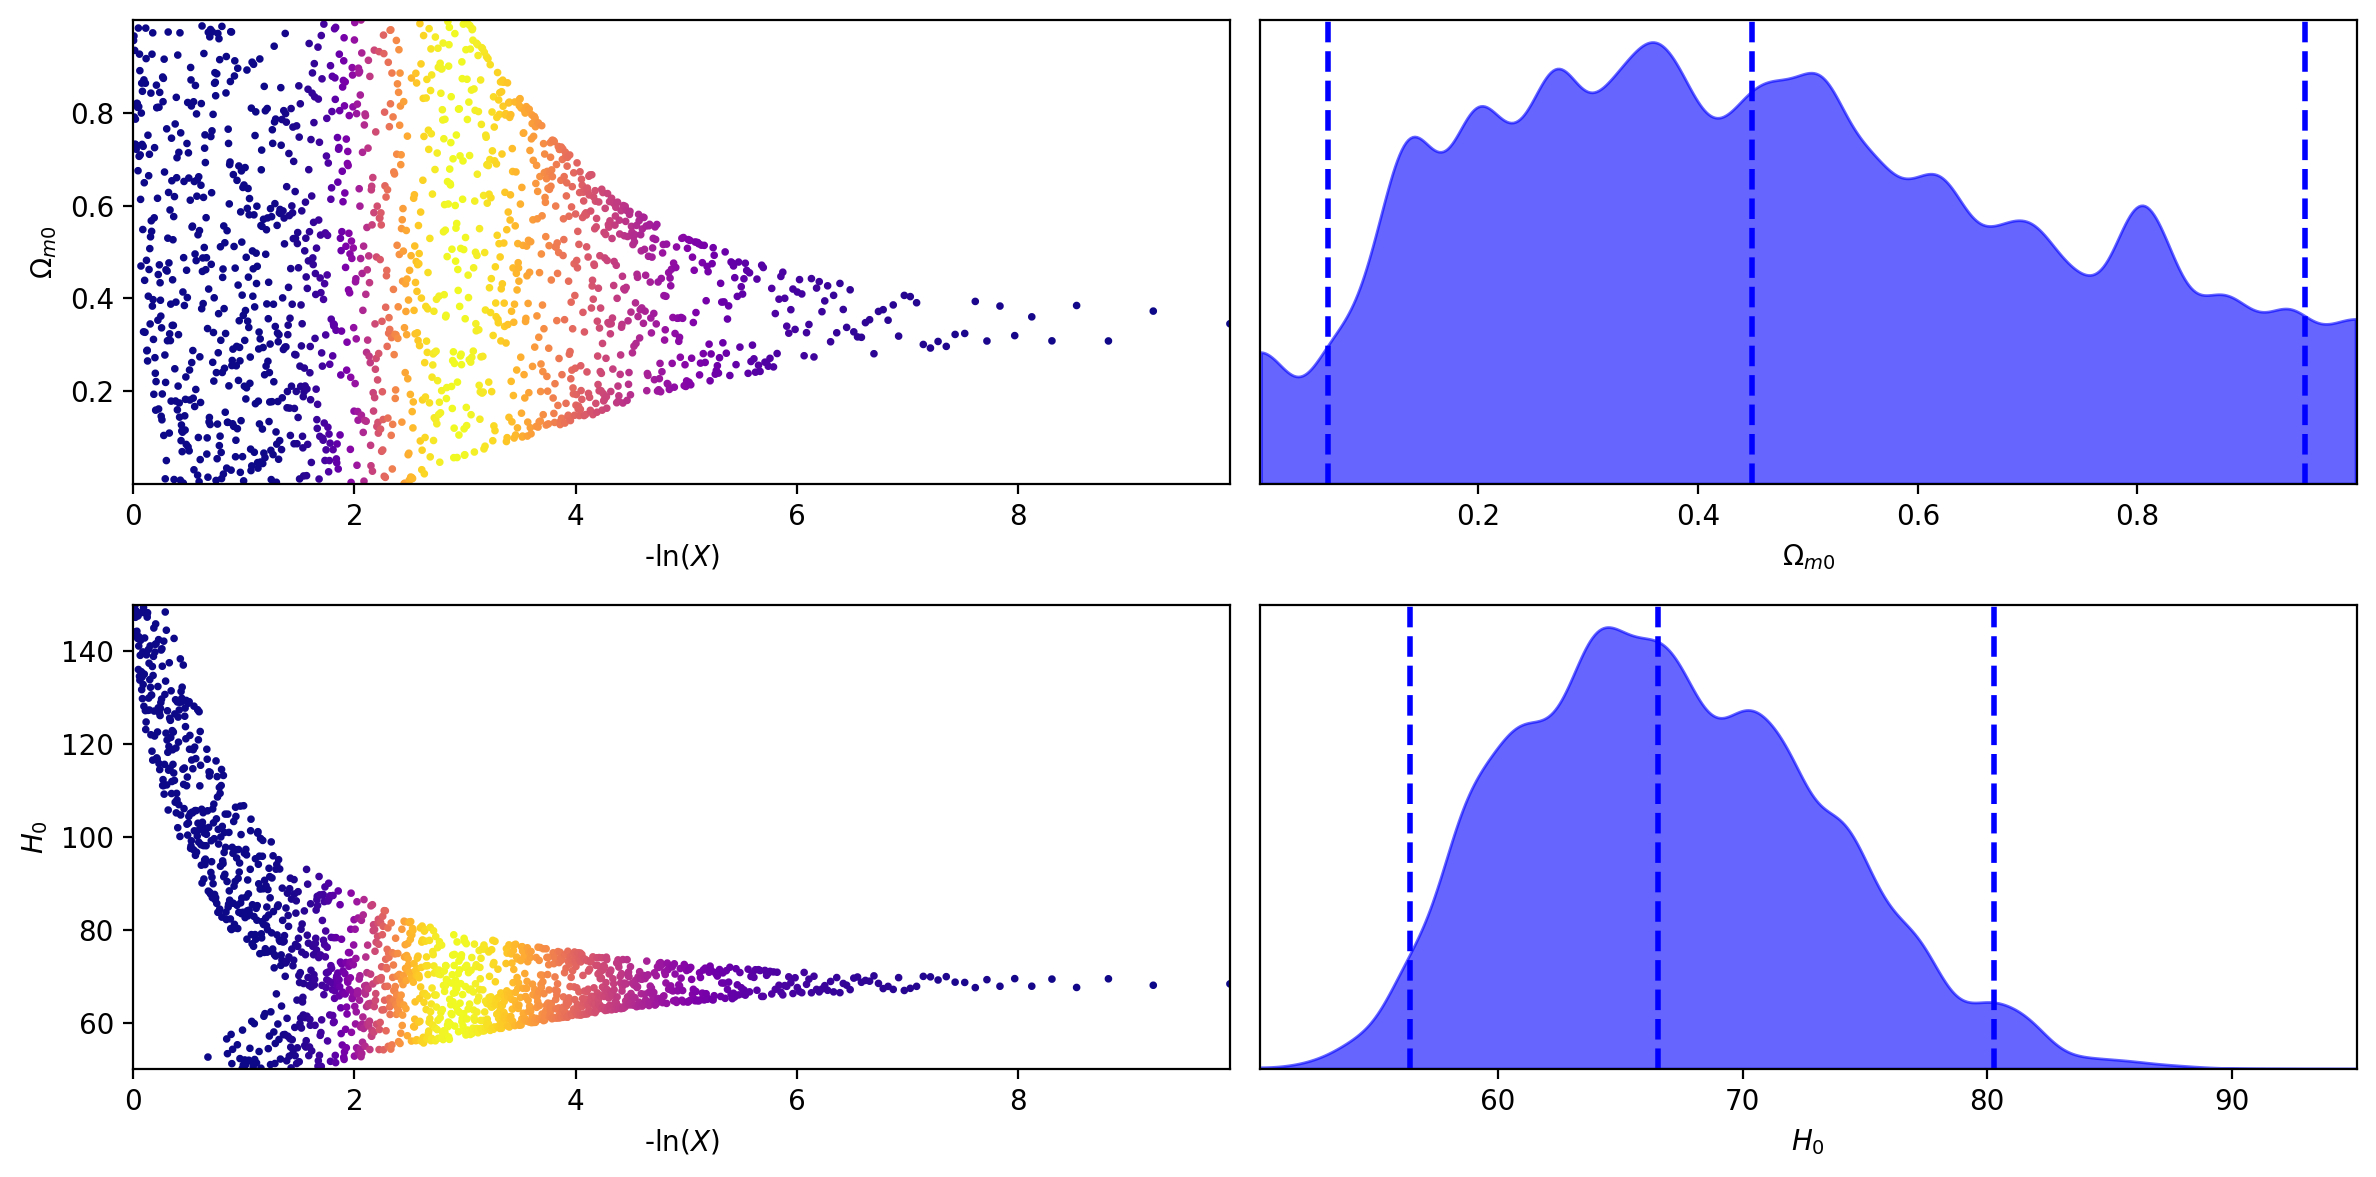

In [37]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(sample_results, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$\Omega_{m0}$")
taxes[0][1].set_xlabel("$\Omega_{m0}$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$H_0$")
taxes[1][1].set_xlabel("$H_0$")


tfig.tight_layout()

In [38]:
from dynesty import utils as dyfunc

# Extract sampling results (replace sample_results with the actual variable containing your results).
samples = sample_results.samples  # samples, a 2D array: [n_samples, n_parameters]
weights = np.exp(sample_results.logwt - sample_results.logz[-1])  # normalized weights

# Compute 68% parameter credible regions (16%-84% quantiles).
quantiles = [dyfunc.quantile(samples[:, i], [0.16, 0.84], weights=weights) for i in range(samples.shape[1])]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance of parameters.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

68% parameter credible regions are:
 [[0.19930523407391598, 0.7697806214535693], [60.48948802154039, 73.67407042882378]]

Mean and covariance of parameters are: [ 0.46988691 66.99716119]
[[ 0.06278033 -1.35308969]
 [-1.35308969 38.778936  ]]


In [39]:
# Resample weighted samples --> Out: new array of samples with equal weights
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.resample_run(sample_results)

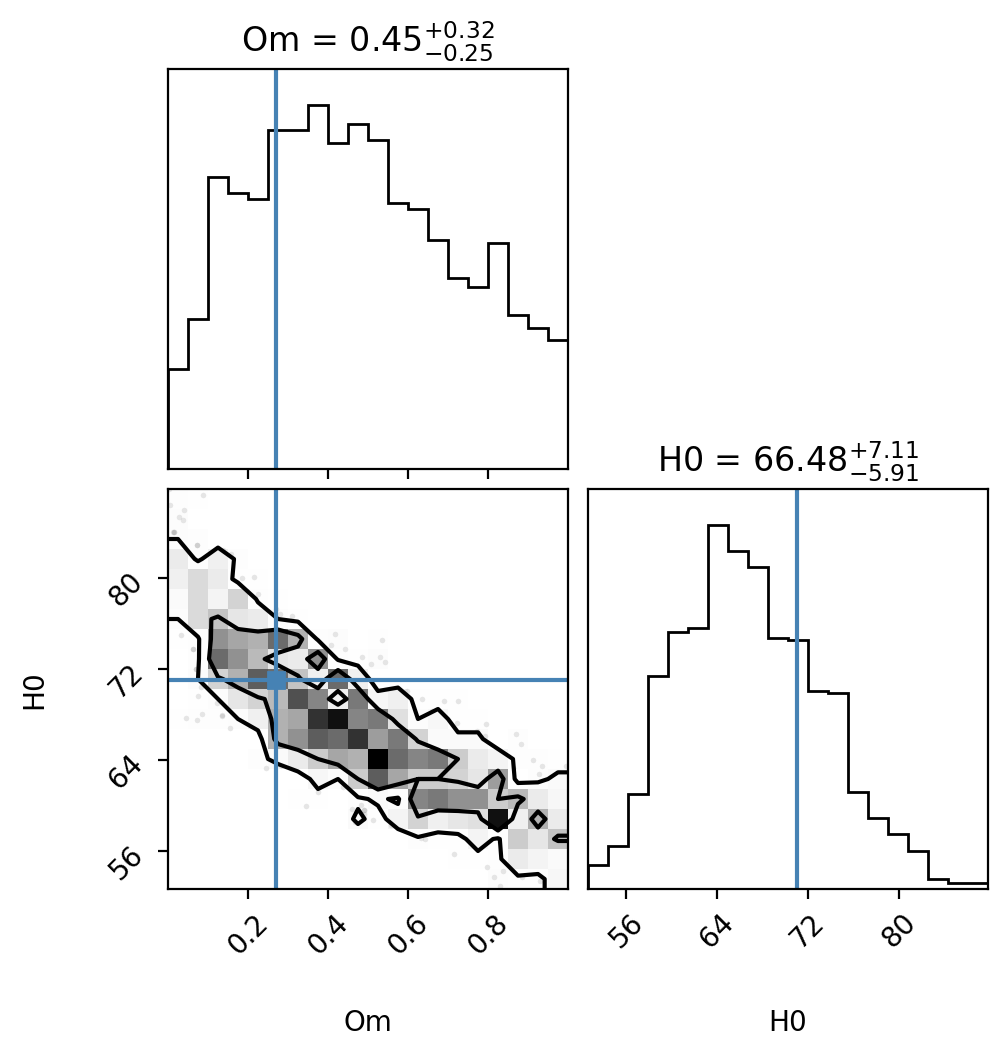

In [40]:
fig = corner.corner(
    samples_equal, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

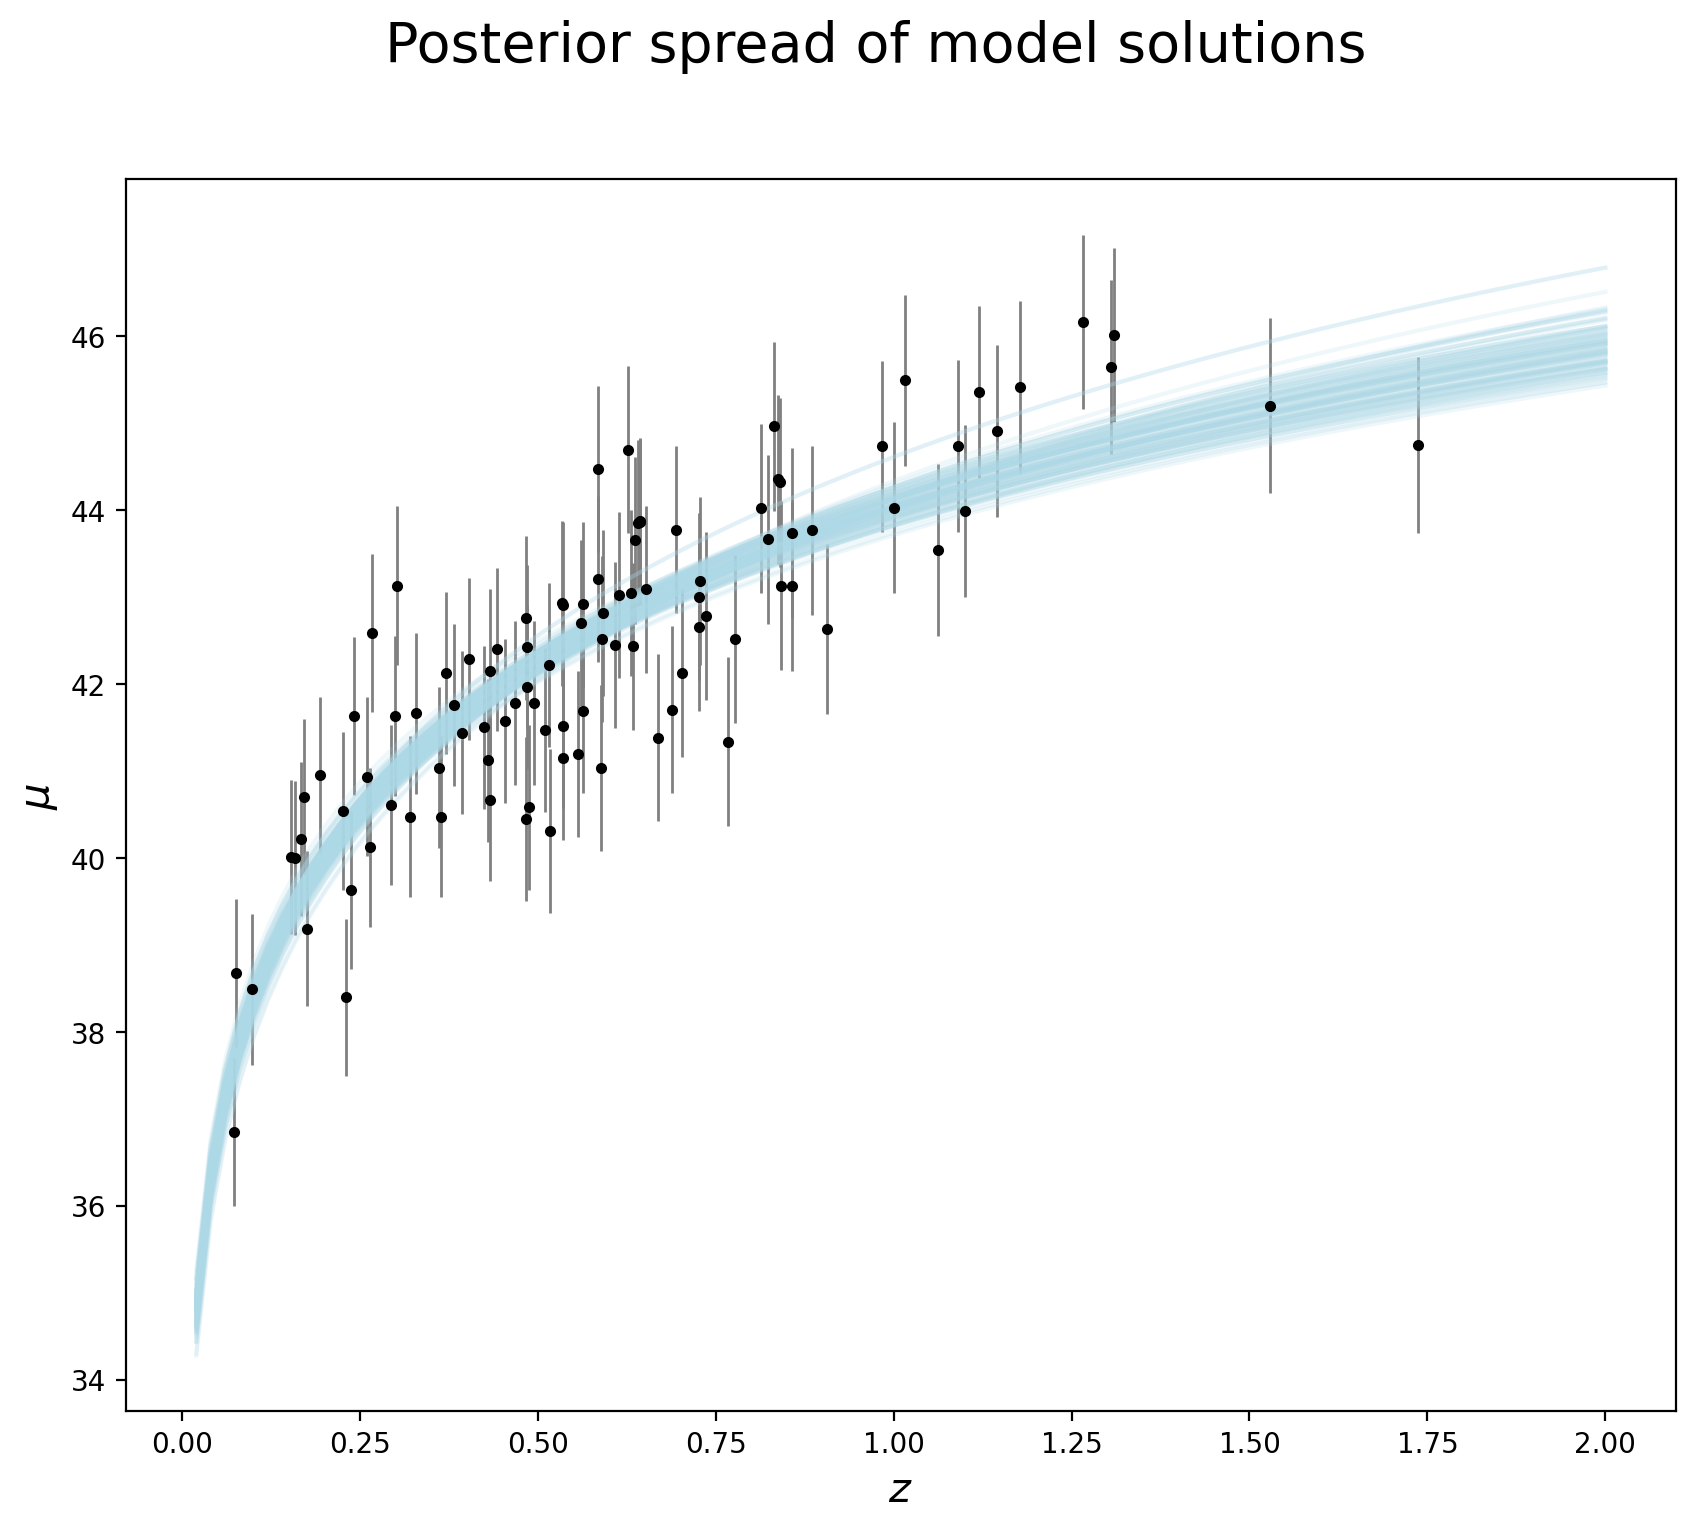

In [42]:
import scipy.stats
z_plot = np.linspace(0,2,100)

#plot section:

plt.figure(figsize=(10, 8))
plt.errorbar(dataset_sorted[:, 0], dataset_sorted[:, 1], dataset_sorted[:,2], fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("$z$", size=15)
plt.ylabel("$\mu$", size=15)
plt.suptitle("Posterior spread of model solutions", size=20);
for i in range(0, 100): 
    
    chosen_post = int(scipy.stats.uniform.rvs(0, len(samples_equal)))
    my_Model = Model(samples_equal[chosen_post], z_plot)
    
    plt.plot(z_plot, my_Model, alpha=0.2, c='lightblue')

## Modeling without $\Lambda$
I will repeat the same as before. Then, in order to select the preferred model, I'll evaluate the **Bayes factor**.

In [65]:
def Model_m(parameter, z):
    H0 = parameter[0]
    curve = FlatLambdaCDM(H0=H0, Om0=1)
    return curve.distmod(z).value

def log_prior_m(parameter):
    H0 = float(parameter)
    
    if 50 < H0 < 100:
        return 0.0
    else:
        return -np.inf

def log_likelihood_m(parameter, z, mu, dmu):
    model = Model_m(parameter, z)

    logL = - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu-model)/dmu)**2)
    return logL
    

def log_posterior_m(parameter, z, mu, dmu):
    return log_likelihood_m(parameter, z, mu, dmu) + log_prior_m(parameter)

### MCMC

In [74]:
n_dim     = 1      # number of parameters (H0, Om0)
n_walkers = 5      # number of MCMC walkers
n_step    = 10000  # number of MCMC steps for each walker

starting_guesses = np.array([80]) + 1e-1* np.random.randn(n_walkers, n_dim)
print('Starting Guesses:')
print(starting_guesses)

Starting Guesses:
[[79.95365823]
 [79.95342702]
 [80.02419623]
 [79.80867198]
 [79.82750822]]


In [75]:
# Run the MCMC Sampling
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_m, args=(dataset[:,0], dataset[:,1], dataset[:,2]))
sampler.run_mcmc(starting_guesses, n_step, progress=True)
None

/tmp/ipykernel_9351/3101305705.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H0 = float(parameter)
100%|████████████████████████████████████| 10000/10000 [01:01<00:00, 161.68it/s]


In [76]:
samples = sampler.get_chain()
samples

array([[[79.90253104],
        [79.9924098 ],
        [80.01462708],
        [79.88819969],
        [79.67924892]],

       [[79.92882854],
        [80.02301523],
        [79.85866946],
        [80.06011439],
        [79.76325298]],

       [[80.04492227],
        [80.15979663],
        [79.70968232],
        [80.09744736],
        [79.88230627]],

       ...,

       [[55.34681758],
        [57.86221318],
        [59.99132033],
        [60.045815  ],
        [54.83942237]],

       [[55.73020599],
        [59.59766535],
        [59.95093659],
        [60.03626998],
        [55.14442519]],

       [[57.22688306],
        [59.4771945 ],
        [59.95093659],
        [60.01527938],
        [54.00030945]]])

Text(0, 0.5, '$H_0$')

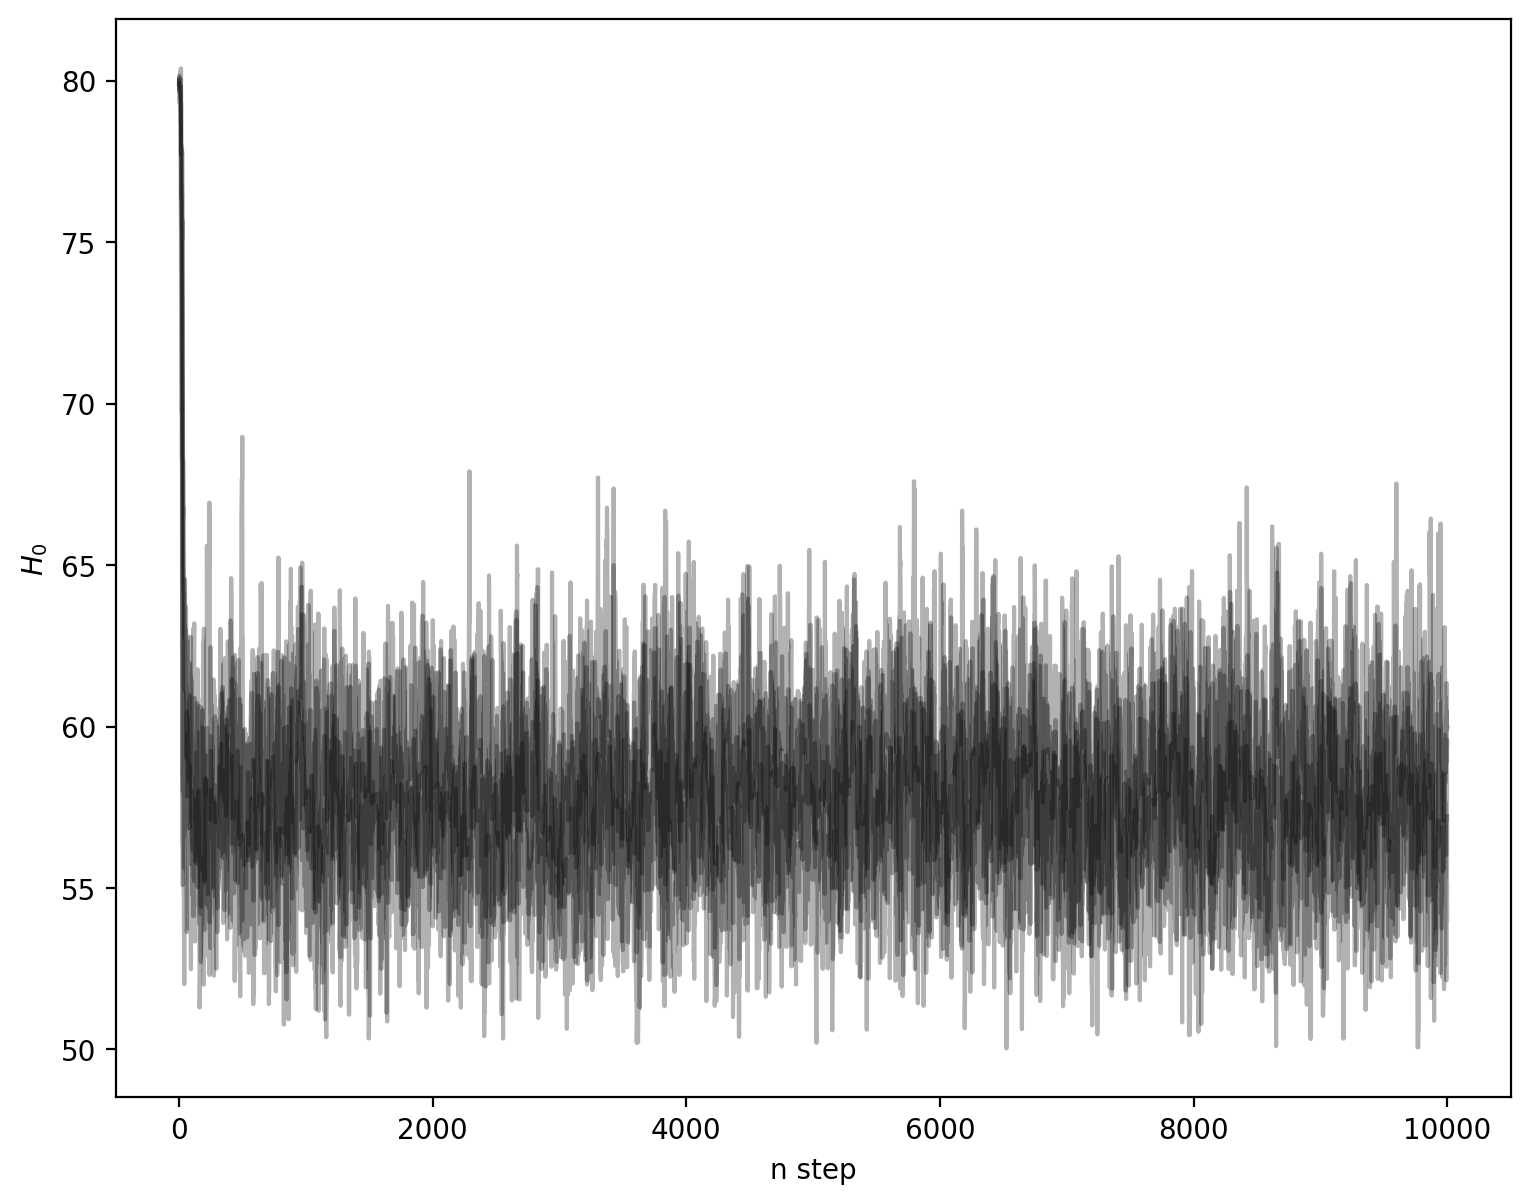

In [77]:
fig, axes = plt.subplots(figsize=(9, 7), sharex=True)
axes.plot(samples[:, :, 0], c='k', alpha=0.3)
axes.set_xlabel('n step')
axes.set_ylabel(r'$H_0$')

In [78]:
tau  = sampler.get_autocorr_time()
burn = 200

flat_samples_m = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True)

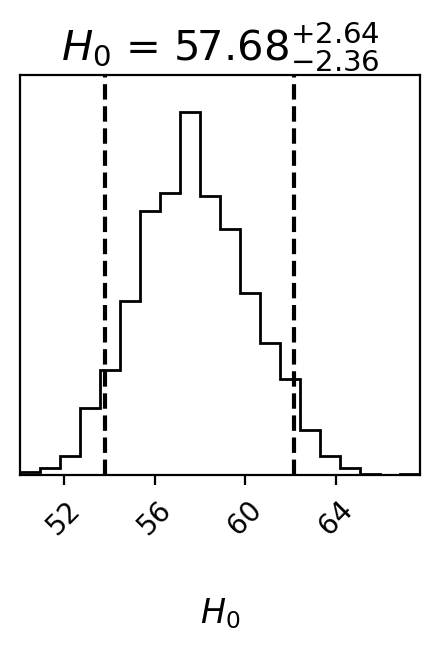

In [79]:
#  Explicitly define the title quantiles (lower, median, upper)
title_quantiles = [0.16, 0.5, 0.84]  # Lower (16%), median (50%), upper (84%) quantiles

# Plotting
fig = corner.corner(
    flat_samples_m, 
    labels=[r"$H_0$"], 
    quantiles=[0.05, 0.95],  # These are for the confidence intervals of the plots
    title_quantiles=title_quantiles,  # Set quantiles to display in the titles
    show_titles=True, 
    title_kwargs={"fontsize": 15}, 
    label_kwargs=dict(fontsize=12)
)

### Nested Sampling

In [80]:
n_dim = 1  # dimensionality of the problem

# Transform for the (here) uniform prior
def ptform_m(parameter): 
    H0 = parameter

    return scipy.stats.uniform.ppf(H0, 50, 100)

def log_likelihood_dynesty_m(parameter, z, mu, dmu):
    model = Model_m(parameter, z)

    logL = - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu-model)/dmu)**2)
    return logL   

In [81]:
sampler = dynesty.NestedSampler(log_likelihood_dynesty_m, ptform_m, n_dim, nlive=300, logl_args=[dataset[:,0], dataset[:,1], dataset[:,2]])

sampler.run_nested()
sample_results = sampler.results

1241it [00:22, 56.01it/s, +300 | bound: 1 | nc: 1 | ncall: 11469 | eff(%): 13.797 | loglstar:   -inf < -133.530 <    inf | logz: -136.337 +/-  0.075 | dlogz:  0.001 >  0.309]


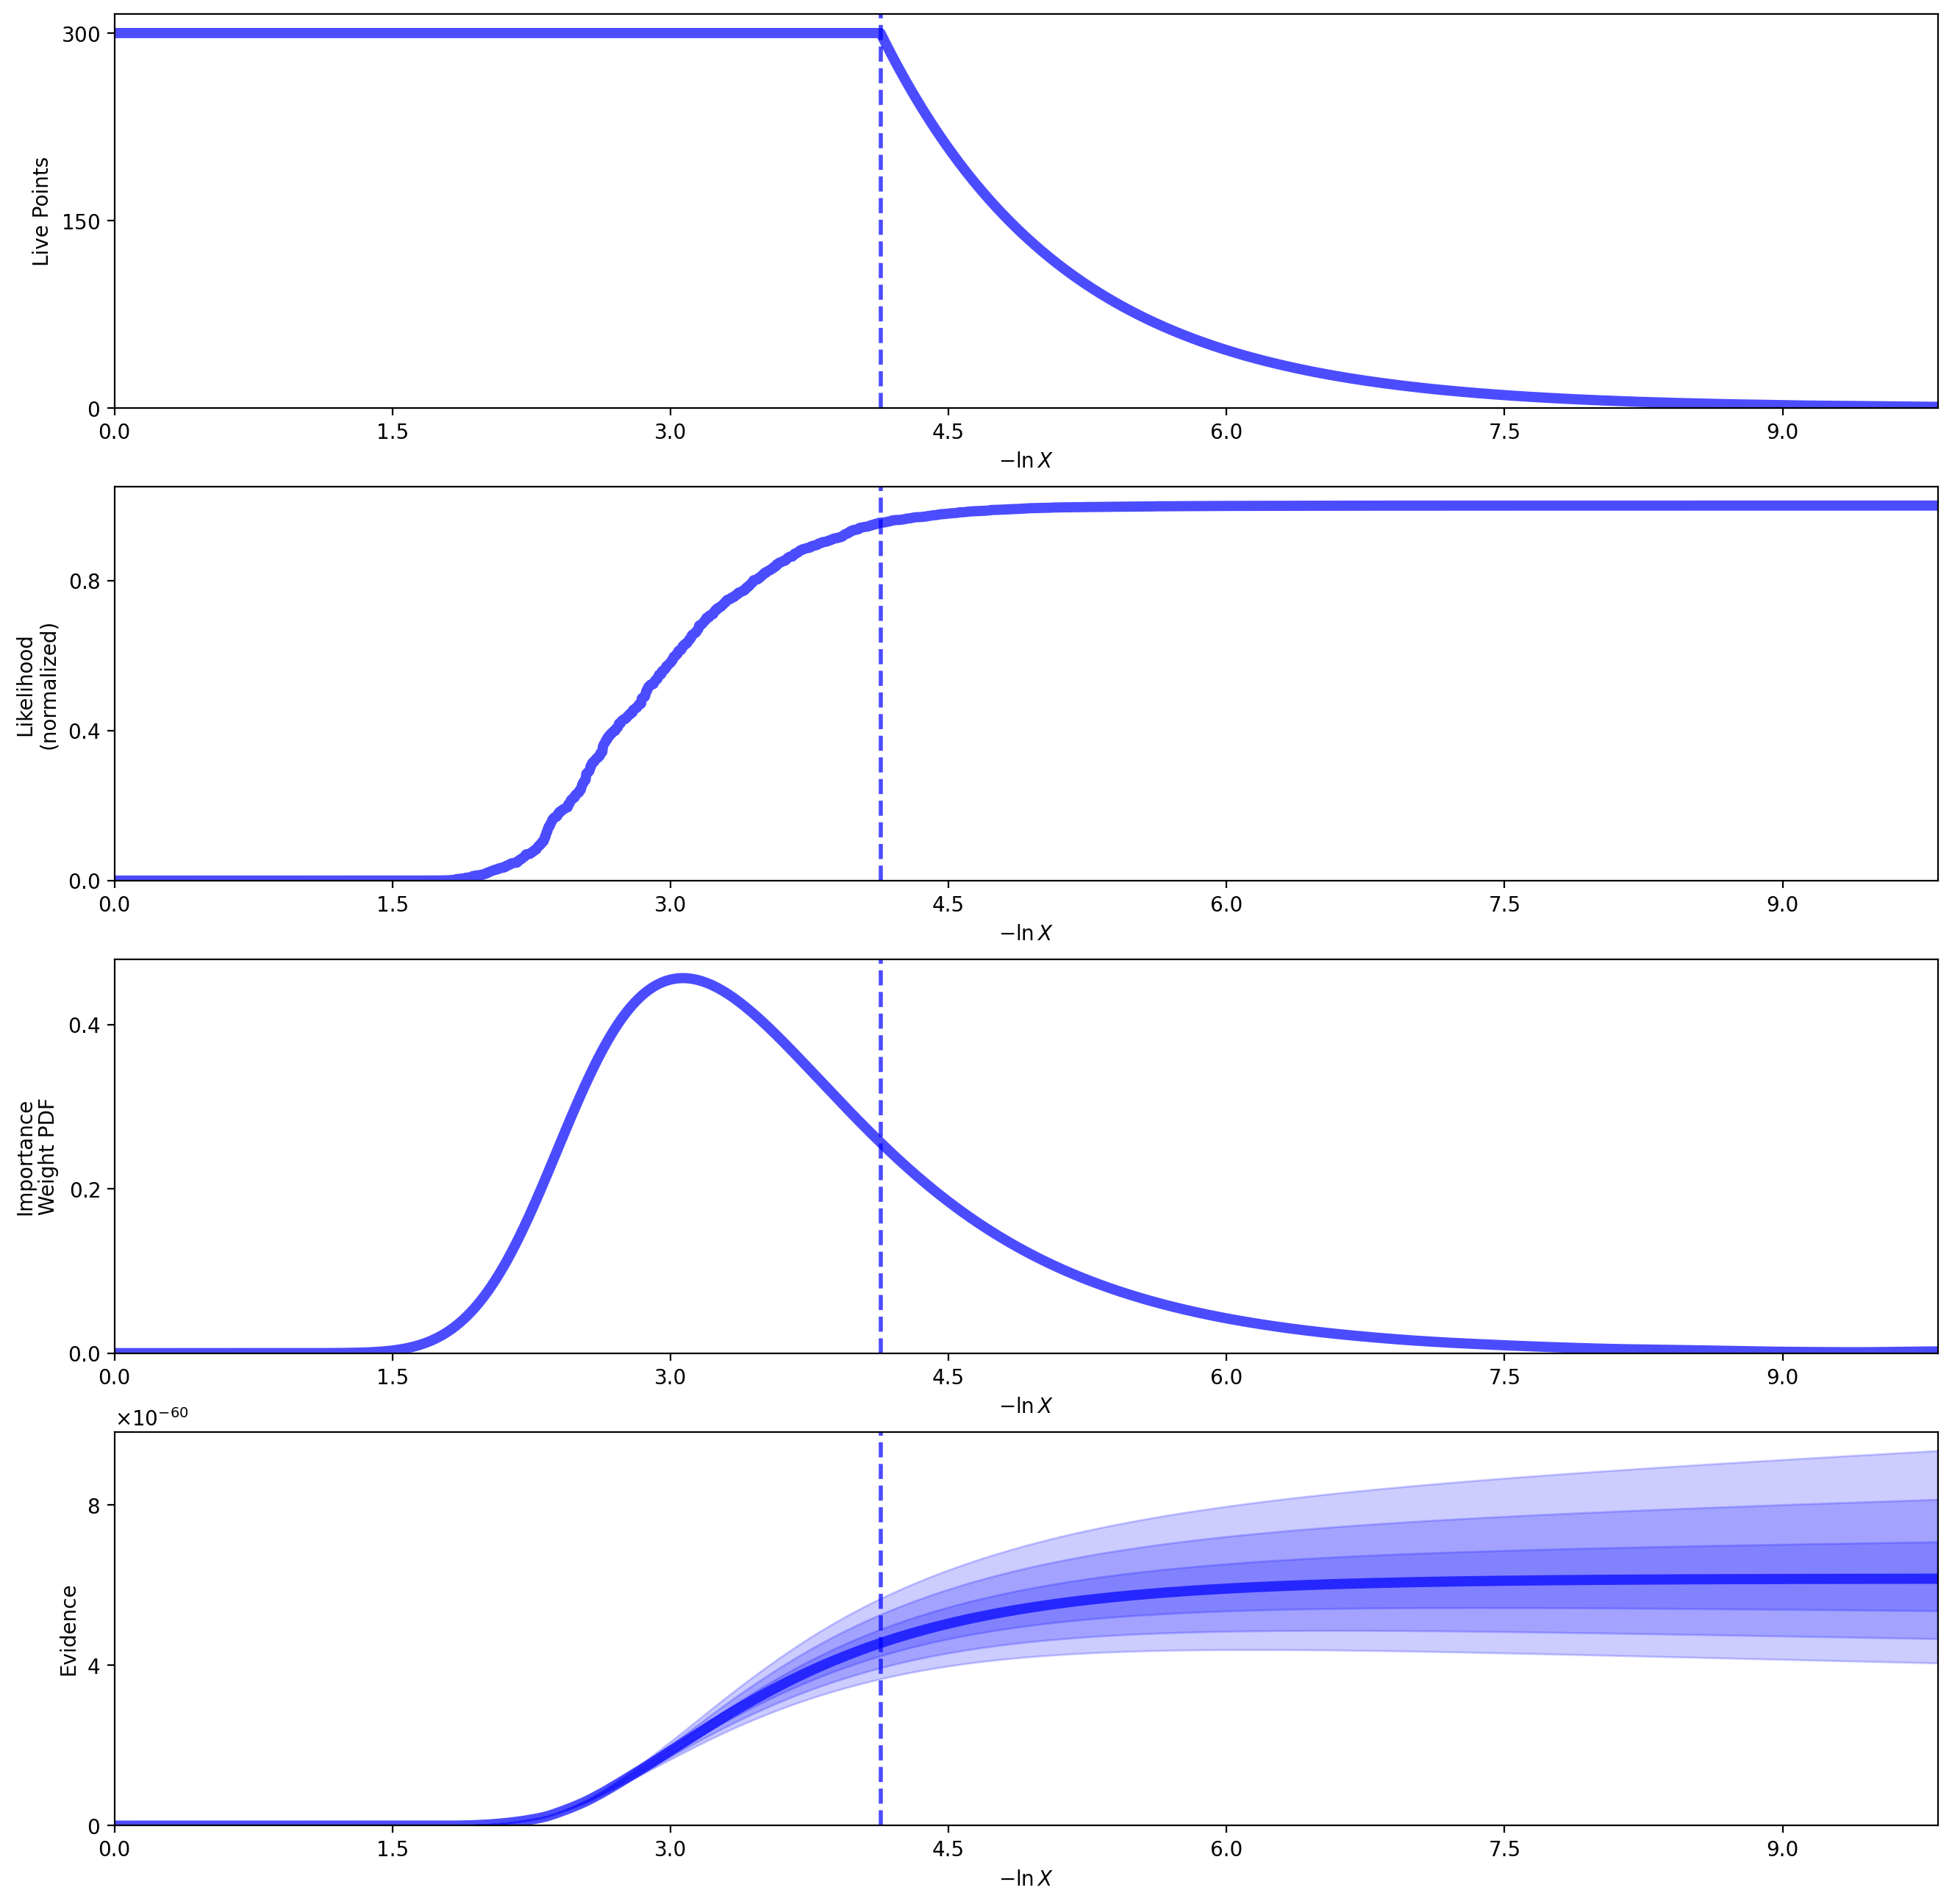

In [82]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sample_results)

In [83]:
logZdynesty_m = sample_results.logz[-1]
logZerrdyn_m  = sample_results.logzerr[-1]

In [84]:
display(Math(fr'\text{{Marginalized Evidence}} = {logZdynesty_m:.2f} \pm {logZerrdyn_m:.2f}'))

<IPython.core.display.Math object>

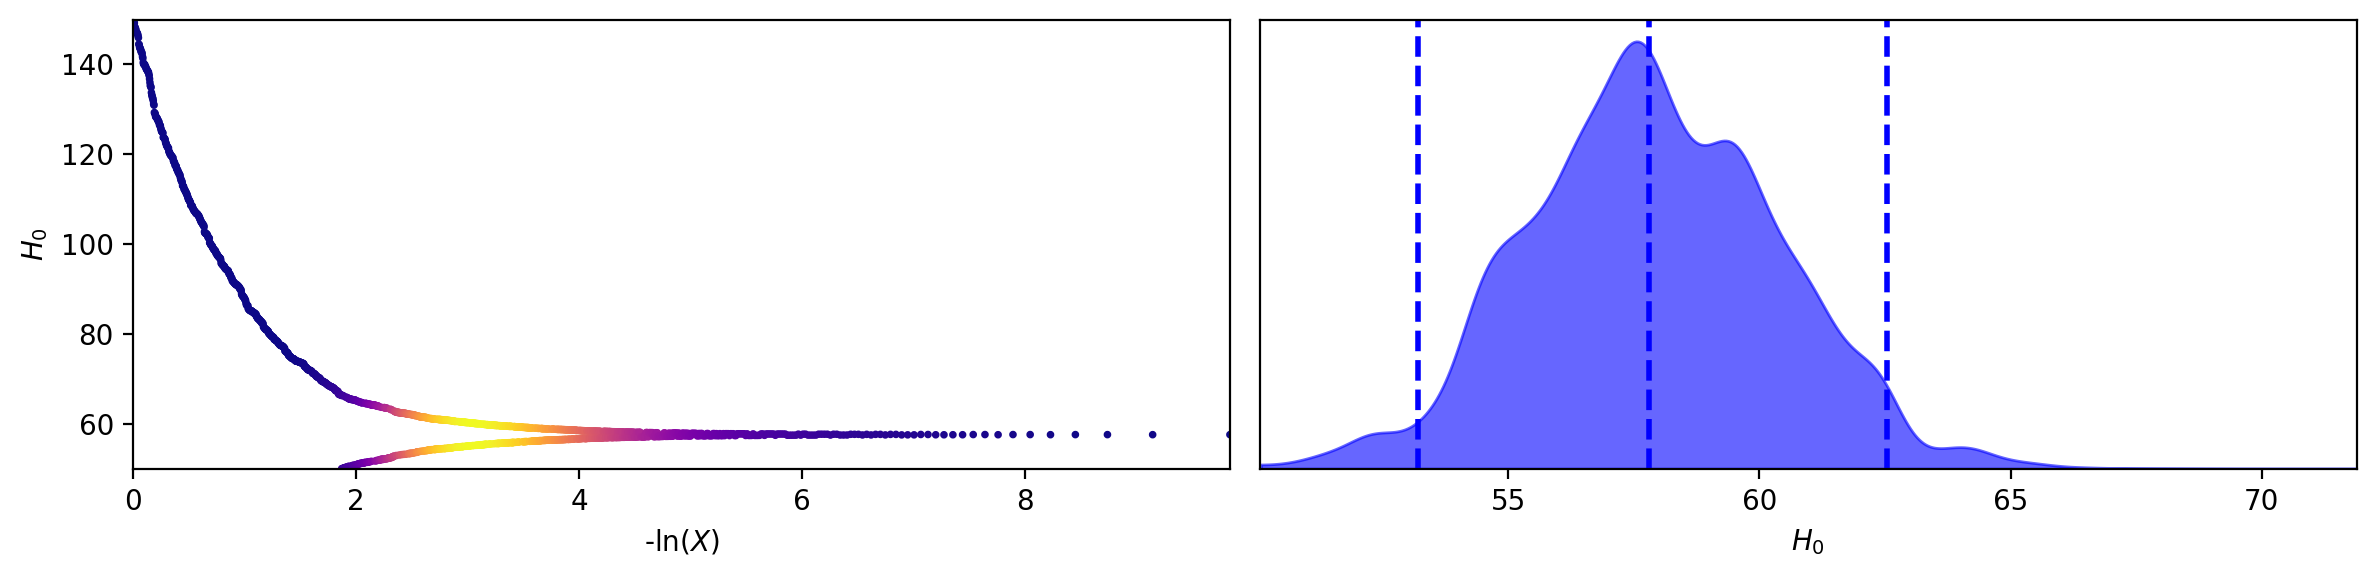

In [85]:
tfig, taxes = dyplot.traceplot(sample_results, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$H_0$")
taxes[0][1].set_xlabel("$H_0$")


tfig.tight_layout()

In [86]:
B_12 = np.exp(logZdynesty) / np.exp(logZdynesty_m)

In [87]:
display(Math(fr'B_{{12}} \sim {B_12:.2f}'))

<IPython.core.display.Math object>

This  means that we have a **weak evidence** in favour of the Model 1 (the one with $\Lambda$).

## Clone the data
### MCMC and Nested

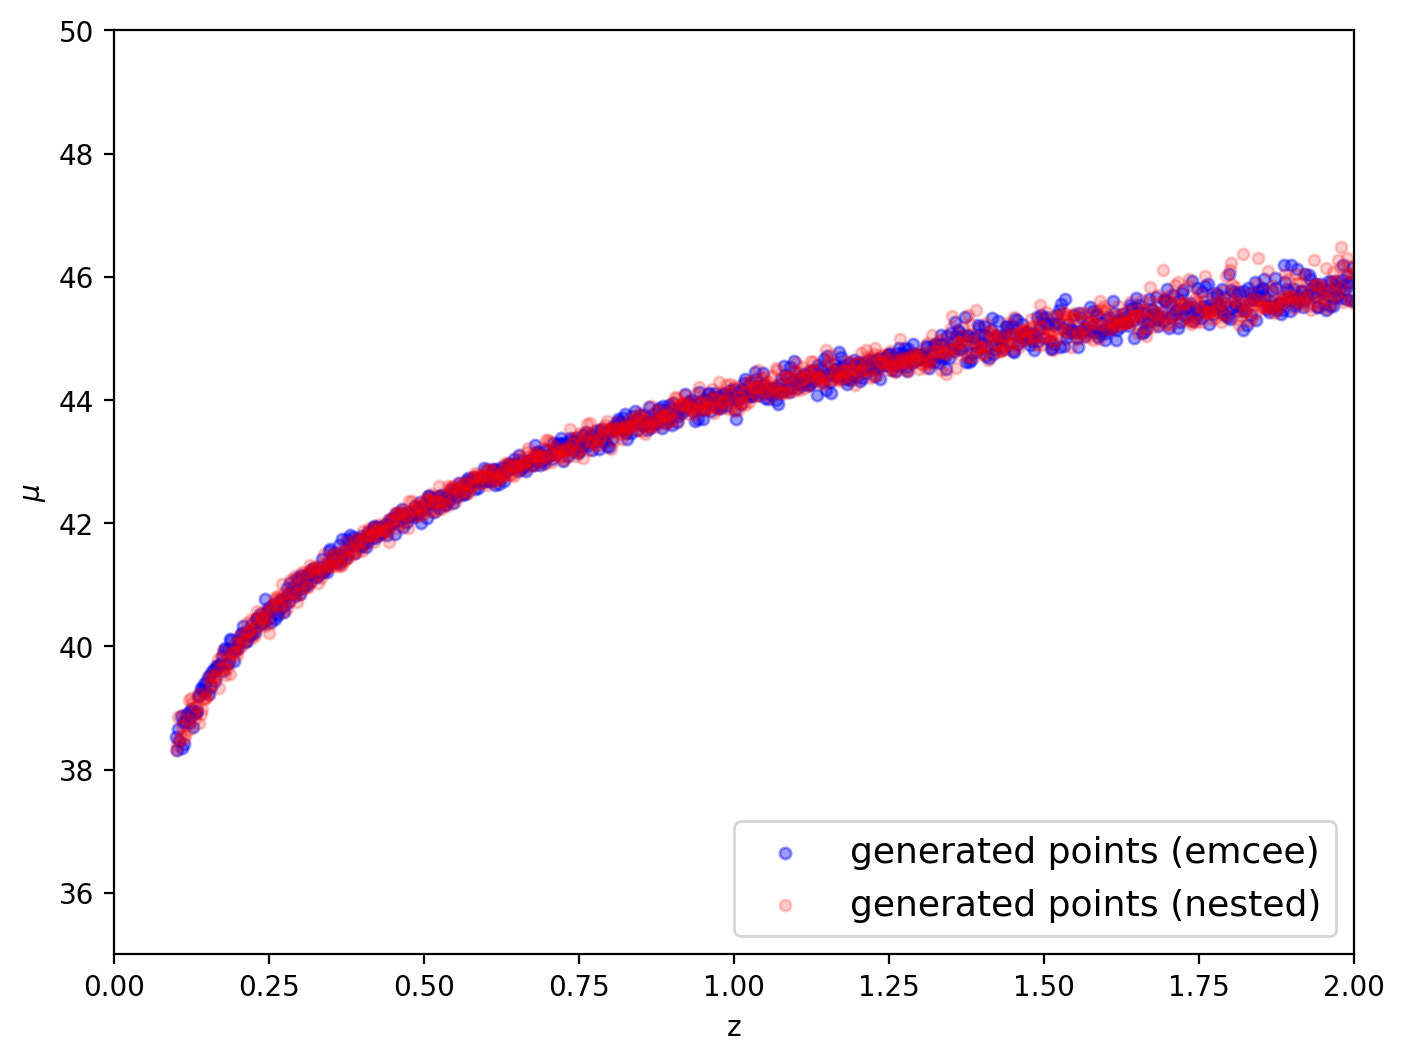

In [89]:
LCDM_emcee  = []
LCDM_nested = []
zs_cloning  = np.linspace(0.1, 2, 1000)  # uniform z distribution

for i in range(0, 1000):

    chosen_emcee  = int(scipy.stats.uniform.rvs(0, len(flat_samples)))
    chosen_nested = int(scipy.stats.uniform.rvs(0, len(samples_equal)))
    
    LCDM_emcee.append(Model(flat_samples[chosen_emcee], zs_cloning[i]))
    LCDM_nested.append(Model(samples_equal[chosen_nested], zs_cloning[i]))
    

plt.figure(figsize=(8, 6))
plt.scatter(zs_cloning, LCDM_emcee, s=16.5, c='blue', alpha=0.4, label='generated points (emcee)') 
plt.scatter(zs_cloning, LCDM_nested, s=16.5, c='red', alpha=0.2, label='generated points (nested)') 
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=13)
plt.xlim(0,2)
plt.ylim(35,50);

### GPR

In [90]:
k = kernels.ConstantKernel(best_constant, (1e-3, 1e3)) * kernels.RBF(best_scale_len, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=k, alpha=(dmu) ** 2, random_state=1)
    
gpr.fit(z_sample.reshape(-1, 1), mu_sample)  # fit with all the elements I have
    
y_pred, dy_pred = gpr.predict(zs_cloning.reshape(-1, 1), return_std=True)

y_extract = norm.rvs(loc=y_pred, scale=dy_pred)  # generate the numbers within the model (with model as mu and error as sigma)


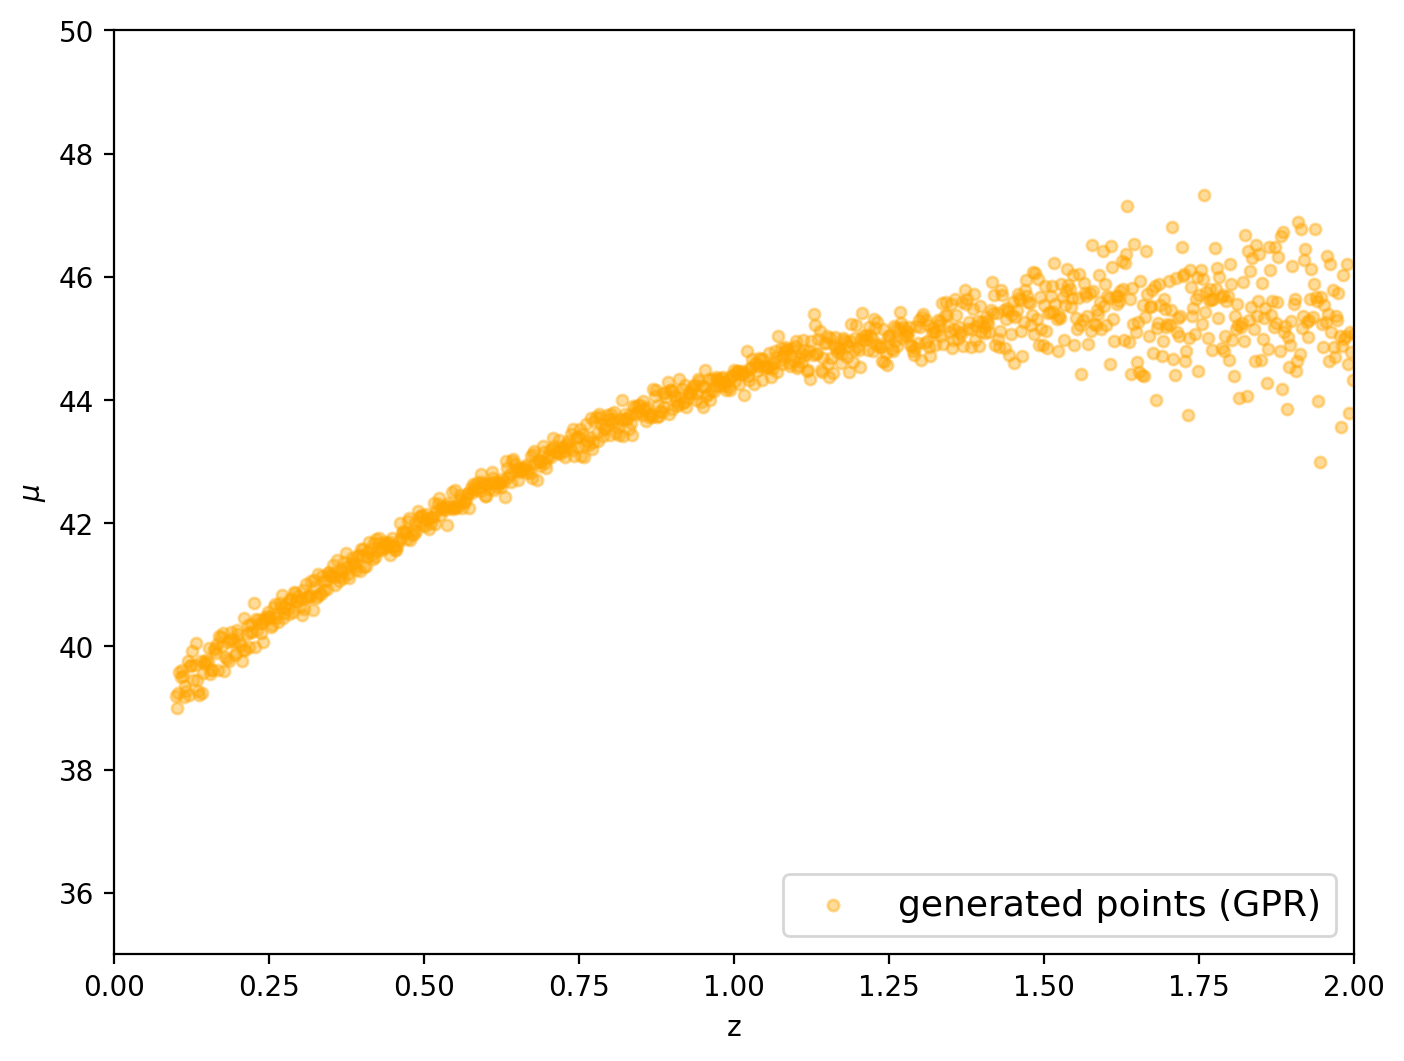

In [91]:
plt.figure(figsize=(8, 6))
plt.scatter(zs_cloning, y_extract, s=16.5, color='orange', alpha=0.4,label='generated points (GPR)') 
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=13)
plt.xlim(0,2)
plt.ylim(35,50);

### let's compare them!

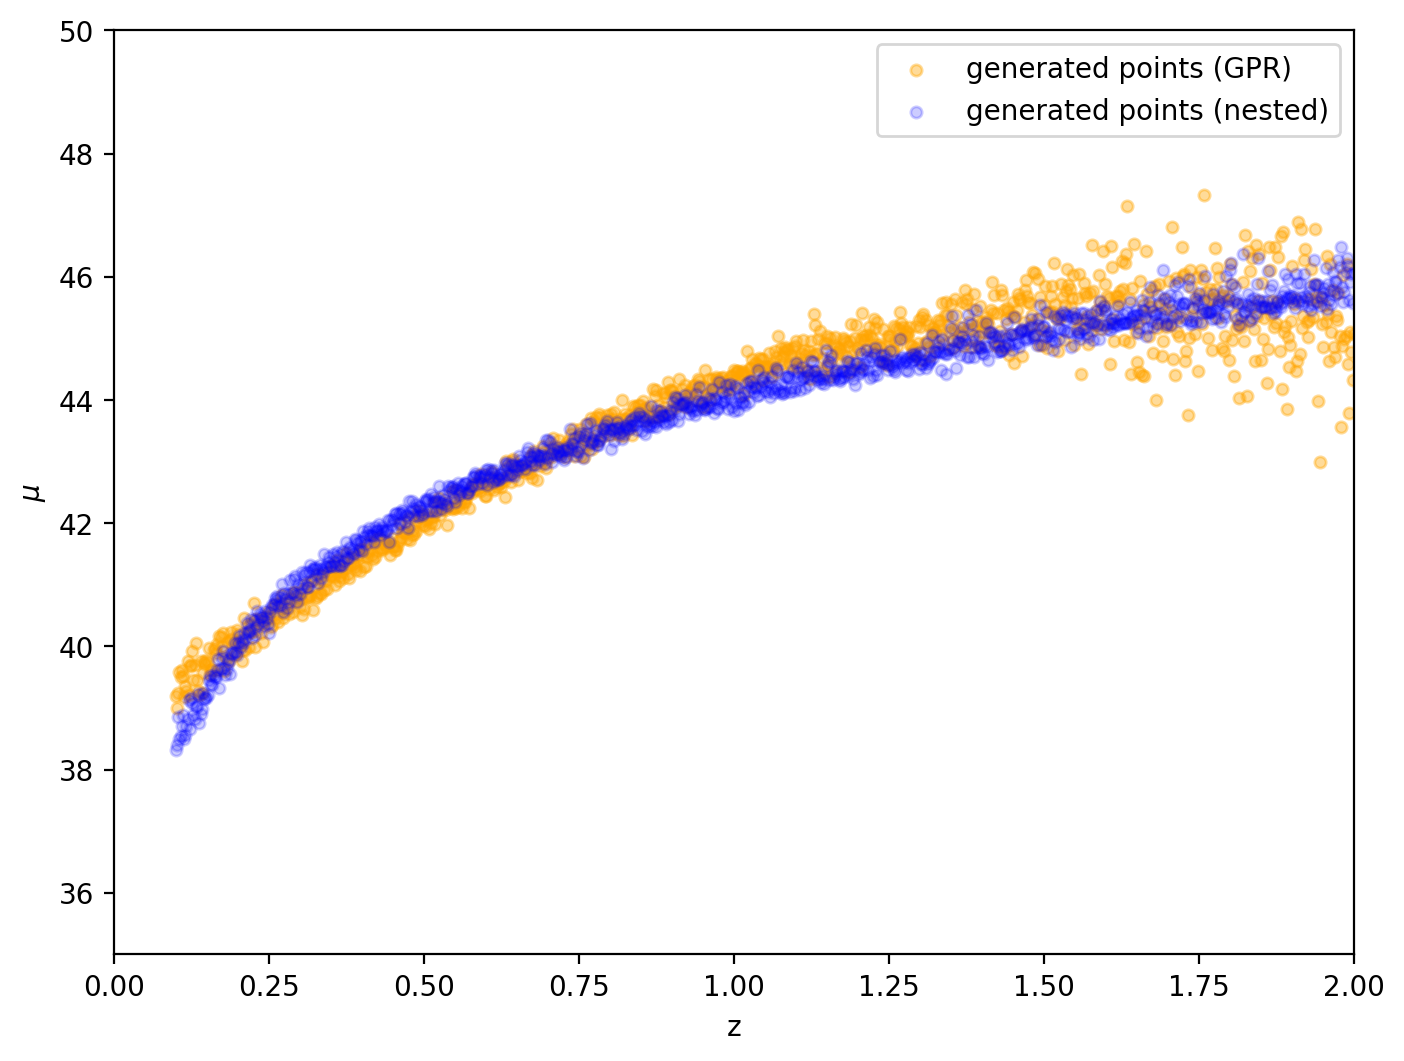

In [92]:
plt.figure(figsize=(8, 6))
plt.scatter(zs_cloning, y_extract, s=16.5, color='orange', alpha=0.4,label='generated points (GPR)') 
plt.scatter(zs_cloning, LCDM_nested, s=16.5, c='blue', alpha=0.2, label='generated points (nested)') 
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=13)
plt.xlim(0,2)
plt.ylim(35,50);
plt.legend();
